# Sentiment analysis and opinion mining of Youtube comments


## Introduction
YouTube is the most popular and most used video platfrom in the world today. YouTube has [a list of **trending videos**](https://www.youtube.com/feed/trending) that is updated constantly. Here we will use **Python** with some packages like **Pandas** and **Matplotlib** to analyze a dataset that was collected over 20 days. For each of those days, the dataset contains data about the trending videos of that day. It contains data about **more than `1000` trending videos**. We will analyze this data to get insights into YouTube trending videos, to see what is common between these videos. Those insights might also be used by people who want to increase popularity of their videos on YouTube.

The dataset that we will use is obtained from Youtube API. It contains data about trending videos for many countries. Here we will analyze USA trending videos. 

## Goals of the project
We want to answer questions like:
* What makes a youtube video go trending?
* Which YouTube channels have the largest number of trending videos?
* Obtaining gross viewer feedback and opinion mining of a particular video (obtained by running Sentiment Analysis on comments left by viewers).

## Target Audience
Our target audience are the content creators on YouTube.


## <a name="import"></a>Importing some packages
First, we import some Python packages that will help us analyzing the data, especially `pandas` for data analysis and `matplotlib` for visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

from mpl_toolkits.mplot3d import Axes3D

import googleapiclient.discovery
import os
import spacy

import warnings
from collections import Counter
import datetime
import json
from pandas.io.json import json_normalize 
import datetime
from datetime import datetime
import mpld3
mpld3.enable_notebook()

# Script to collect live data from Youtube API 

```
import requests, sys, time, os, argparse
import mysql.connector
#List of simple to collect features
snippet_features = ["title",
                    "publishedAt",
                    "channelId",
                    "channelTitle",
                    "categoryId"]

#Any characters to exclude, generally these are things that become problematic in CSV files
unsafe_characters = ['\n', '"']

#Used to identify columns, currently hardcoded order
header = ["video_id"] + snippet_features + ["trending_date", "tags", "view_count", "likes", "dislikes",
                                            "comment_count", "thumbnail_link", "comments_disabled",
                                            "ratings_disabled", "description"]

def setup(api_path, code_path):
    with open(api_path, 'r') as file:
        api_key = file.readline().strip()

    with open(code_path) as file:
        country_codes = [x.rstrip() for x in file]

    return api_key, country_codes


def prepare_feature(feature):
    # Removes any character from the unsafe characters list and surrounds the whole item in quotes
    for ch in unsafe_characters:
        feature = str(feature).replace(ch, "")
    return f'"{feature}"'


def api_request(page_token, country_code):
    # Builds the URL and requests the JSON from it
    request_url = f"https://www.googleapis.com/youtube/v3/videos?part=id,statistics,snippet{page_token}chart=mostPopular&regionCode={country_code}&maxResults=50&key={api_key}"
    request = requests.get(request_url)
    if request.status_code == 429:
        print("Temp-Banned due to excess requests, please wait and continue later")
        sys.exit()
    if request.status_code == 400:
        print("Error")
        sys.exit()
    return request.json()

def setup_db(conn):
    cur = conn.cursor()
    table_schema = 'CREATE TABLE IF NOT EXISTS %s_videos (video_id VARCHAR(20) NOT NULL PRIMARY KEY, title TEXT, publishedAt DATETIME,channelId VARCHAR(50),\
    channelTitle TEXT,categoryId INT,trending_date DATETIME,tags TEXT,view_count INT,likes INT,dislikes INT,comment_count INT,\
    thumbnail_link TEXT,comments_disabled TEXT,ratings_disabled TEXT,description TEXT) DEFAULT CHARSET=utf8;'
    for country_code in country_codes:
        #query_str = "CREATE TABLE IF NOT EXISTS %s_videos (%s);" % (country_code,",".join(x + ' TEXT' for x in header))
        cur.execute(table_schema % ( country_code ))
    conn.commit()
        
import pdb
if __name__ == "__main__":

    parser = argparse.ArgumentParser()
    parser.add_argument('--key_path', help='Path to the file containing the api key, by default will use api_key.txt in the same directory', default='api_key.txt')
    parser.add_argument('--country_code_path', help='Path to the file containing the list of country codes to scrape, by default will use country_codes.txt in the same directory', default='country_codes.txt')
    parser.add_argument('--db_name', help='Name of the database file where to store the data', default='youtube_data.db')
    parser.add_argument('--output_dir', help='Path to save the outputted files in', default='output/')

    args = parser.parse_args()

    output_dir = args.output_dir
    db_name = args.db_name
    api_key, country_codes = setup(args.key_path, args.country_code_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    conn = mysql.connector.connect(user='root',host='127.0.0.1',database='youtube_data')
    setup_db(conn)
    get_data()
    conn.close()
```    

The above script collects data from Official Youtube API and saves the data obtained on Amazon web server. We connect to the Youtube API by providing a unique API key.  

![alt text](script_run.png)

Here we can see data collected for different regions like US, Europe, Japan, Mexico etc
From the timestamps we can observe that the script runs once every 5 minutes and if new data is present it is stored or else no operation is performed. 

![alt_text](DATABASE.png)

In [2]:
# Hiding warnings for cleaner display
warnings.filterwarnings('ignore')

# Configuring some options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# If you want interactive plots, uncomment the next line
# %matplotlib notebook

## <a name="read"></a>Reading the dataset
Then we read the dataset file which is in csv format

In [3]:
df = pd.read_csv('us_videos_new.csv')
non_df = pd.read_csv('non_trending_us_videos.csv') 

## <a name="feel"></a>Getting a feel of the dataset
Let's get a feel of our dataset by displaying its first few rows

For Trending Videos.  
Here we can get an overview of different columns in our dataset like `trending_date`, `view_count`, `Likes`, `dislikes` etc

In [4]:
df.head()

,video_id,title,published_at,channel_id,channel_title,category_id,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,rating_disabled,description
0,iN3ttHug-BU,I've been Banned from Fortnite (I'm Sorry),03-11-2019 17:32,UCvxfEIG3PHpgM0TMJJ_SH-w,Jarvis,20,05-11-2019 01:00,faze kay little brother|jarvis|fortnite kid|fo...,2787171,236563,34681,106245,https://i.ytimg.com/vi/iN3ttHug-BU/default.jpg,False,False,I'm sorry
1,qjsU5876iB0,HIGHLIGHTS | Canelo vs. Sergey Kovalev,03-11-2019 06:42,UCurvRE5fGcdUgCYWgh-BDsg,DAZN USA,17,05-11-2019 01:00,canelo|canelo kovalev|dazn|boxing|sergey koval...,4588294,45219,4756,9584,https://i.ytimg.com/vi/qjsU5876iB0/default.jpg,False,False,Big fights. Any device. One price. DAZN is the...
2,93qq-6Sydsk,Patriots vs. Ravens Week 9 Highlights | NFL 2019,04-11-2019 04:30,UCDVYQ4Zhbm3S2dlz7P1GBDg,NFL,17,05-11-2019 01:00,sp:ty=high|sp:dt=2019-11-04T01:20:00Z|sp:st=fo...,2645930,34320,1848,10807,https://i.ytimg.com/vi/93qq-6Sydsk/default.jpg,False,False,The New England Patriots take on the Baltimore...
3,no6hSNBB32w,Jason Mitchell Speaks On Misconduct Allegation...,04-11-2019 13:03,UChi08h4577eFsNXGd3sxYhw,Breakfast Club Power 105.1 FM,24,05-11-2019 01:00,the breakfast club|breakfast club|power1051|ce...,378778,6600,665,6555,https://i.ytimg.com/vi/no6hSNBB32w/default.jpg,False,False,Jason Mitchell drops in to talk the sexual mis...
4,xiXusdahIPw,Boat Stuck At Niagara Falls For More Than 100 ...,04-11-2019 00:26,UCeY0bbntWzzVIaj2z3QigXg,NBC News,25,05-11-2019 01:00,Nightly News|World|NBC Nightly News with Leste...,549085,5302,502,803,https://i.ytimg.com/vi/xiXusdahIPw/default.jpg,False,False,Heavy rains and wind managed to move a massive...


For Non-Trending Videos  
This dataframe contains the non trending videos

In [5]:
non_df.head()

,video_id,title,published_at,channel_id,channel_title,category_id,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,rating_disabled,description
0,KQHHF-IQFE8,Carmelo Anthony Drops Season-HIGH 25 Points Fu...,26-11-2019 03:12,UCqQo7ewe87aYAe7ub5UqXMw,House of Highlights,17,01-12-2019 19:53,carmelo anthony|carmelo anthony full game high...,82520,1660,15,583,https://i.ytimg.com/vi/KQHHF-IQFE8/default.jpg,False,False,Portland Trail Blazers vs Chicago Bulls - Full...
1,-7heK6LRfLU,Exclusive Audio: Jay Leno Dines With Ukraine P...,22-11-2019 08:35,UCMtFAi84ehTSYSE9XoHefig,The Late Show with Stephen Colbert,24,01-12-2019 19:53,The Late Show|Late Show|Stephen Colbert|Steven...,235641,2538,139,264,https://i.ytimg.com/vi/-7heK6LRfLU/default.jpg,False,False,The Late Show has acquired the audio from Jay ...
2,#NAME?,B/R Countdown: LeBron James All-Time Triple Do...,22-11-2019 17:38,UC9-OpMMVoNP5o10_Iyq7Ndw,Bleacher Report,17,01-12-2019 19:53,bleacher report|br|nba|lebron james|lebron jam...,8344,208,5,28,https://i.ytimg.com/vi/-ZnV8WDBAwo/default.jpg,False,False,The King will be remembered as one of the all-...
3,1b30OxMjrWo,Nice Garry! Lyon leads clinic ahead of Adelaid...,27-11-2019 07:45,UCkBY0aHJP9BwjZLDYxAQrKg,cricket.com.au,17,01-12-2019 19:53,[none],13400,482,17,25,https://i.ytimg.com/vi/1b30OxMjrWo/default.jpg,False,False,Australia spinner Nathan Lyon led a clinic wit...
4,fKAixUpvJD8,Media lauds McGahn decision as silver bullet,27-11-2019 03:53,UCXIJgqnII2ZOINSWNOGFThA,Fox News,25,01-12-2019 19:53,politics|personality|politics|trump_impeachmen...,48854,816,46,272,https://i.ytimg.com/vi/fKAixUpvJD8/default.jpg,False,False,Reaction and analysis from Claremont Institute...


Now, let's see some information about our dataset

## Dataframe Statistics

#### For Trending Videos

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122 entries, 0 to 1121
Data columns (total 16 columns):
video_id             1122 non-null object
title                1119 non-null object
published_at         1122 non-null object
channel_id           1122 non-null object
channel_title        1122 non-null object
category_id          1122 non-null int64
trending_date        1122 non-null object
tags                 1122 non-null object
view_count           1122 non-null int64
likes                1122 non-null int64
dislikes             1122 non-null int64
comment_count        1122 non-null int64
thumbnail_link       1122 non-null object
comments_disabled    1122 non-null bool
rating_disabled      1122 non-null bool
description          1113 non-null object
dtypes: bool(2), int64(5), object(9)
memory usage: 125.0+ KB


We can see that there are `1122` entries in the dataset. We can see also that all columns in the dataset are complete (i.e. they have `1122` non-null entries) except `description` & `title` columns which have some `null` values; it only has `9` & `3` null values respectively.

#### For Non-Trending Videos

In [7]:
non_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 16 columns):
video_id             473 non-null object
title                471 non-null object
published_at         473 non-null object
channel_id           473 non-null object
channel_title        469 non-null object
category_id          473 non-null int64
trending_date        473 non-null object
tags                 473 non-null object
view_count           473 non-null int64
likes                473 non-null int64
dislikes             473 non-null int64
comment_count        473 non-null int64
thumbnail_link       473 non-null object
comments_disabled    473 non-null bool
rating_disabled      473 non-null bool
description          461 non-null object
dtypes: bool(2), int64(5), object(9)
memory usage: 52.8+ KB


We can see that there are `473` entries in the **non-trending** dataset. We can see also that all columns in the dataset are complete (i.e. they have `473` non-null entries) except `description`, `title` & `Channel Title` columns which have some `null` values; it only has `2`, `12` & `4` null values respectively.

We set some configuration options just for improving visualization graphs; nothing crucial

In [8]:
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', family='Arial', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)

## <a name="descn"></a>Description of numerical columns
Now, let's see some statistical information about the numerical columns of our dataset

In [9]:
df.describe()

,category_id,view_count,likes,dislikes,comment_count
count,1122.00,1122.00,1122.00,1122.00,1122.00
mean,19.62,1249435.64,65064.04,1854.96,5846.89
std,7.20,1880014.14,115281.14,5494.31,12652.46
min,1.00,0.00,0.00,0.00,0.00
25%,17.00,417417.25,13155.25,319.25,1442.00
50%,23.00,729990.00,30999.50,636.50,2775.00
75%,24.00,1288713.25,65994.00,1473.25,5449.50
max,29.00,22635062.00,1650388.00,91081.00,266924.00


We note from the table above that 
- The average number of views of a video is `1,249,435`. The median value for the number of views is `729,990`, which means that half the videos have views that are less than that number, and the other half have views larger than that number
- The average number of likes of a trending video is `65,064`, while the average number of dislikes is `1,854`. The 
- Average comment count is `5846` while the median is `2,775`

How useful are the observations above? Do they really represent the data? Let's examine more. 

### <a name="vh"></a>Views histogram
let's plot a [histogram](https://www.mathsisfun.com/data/histograms.html) for the `views` column to take a look at its distribution

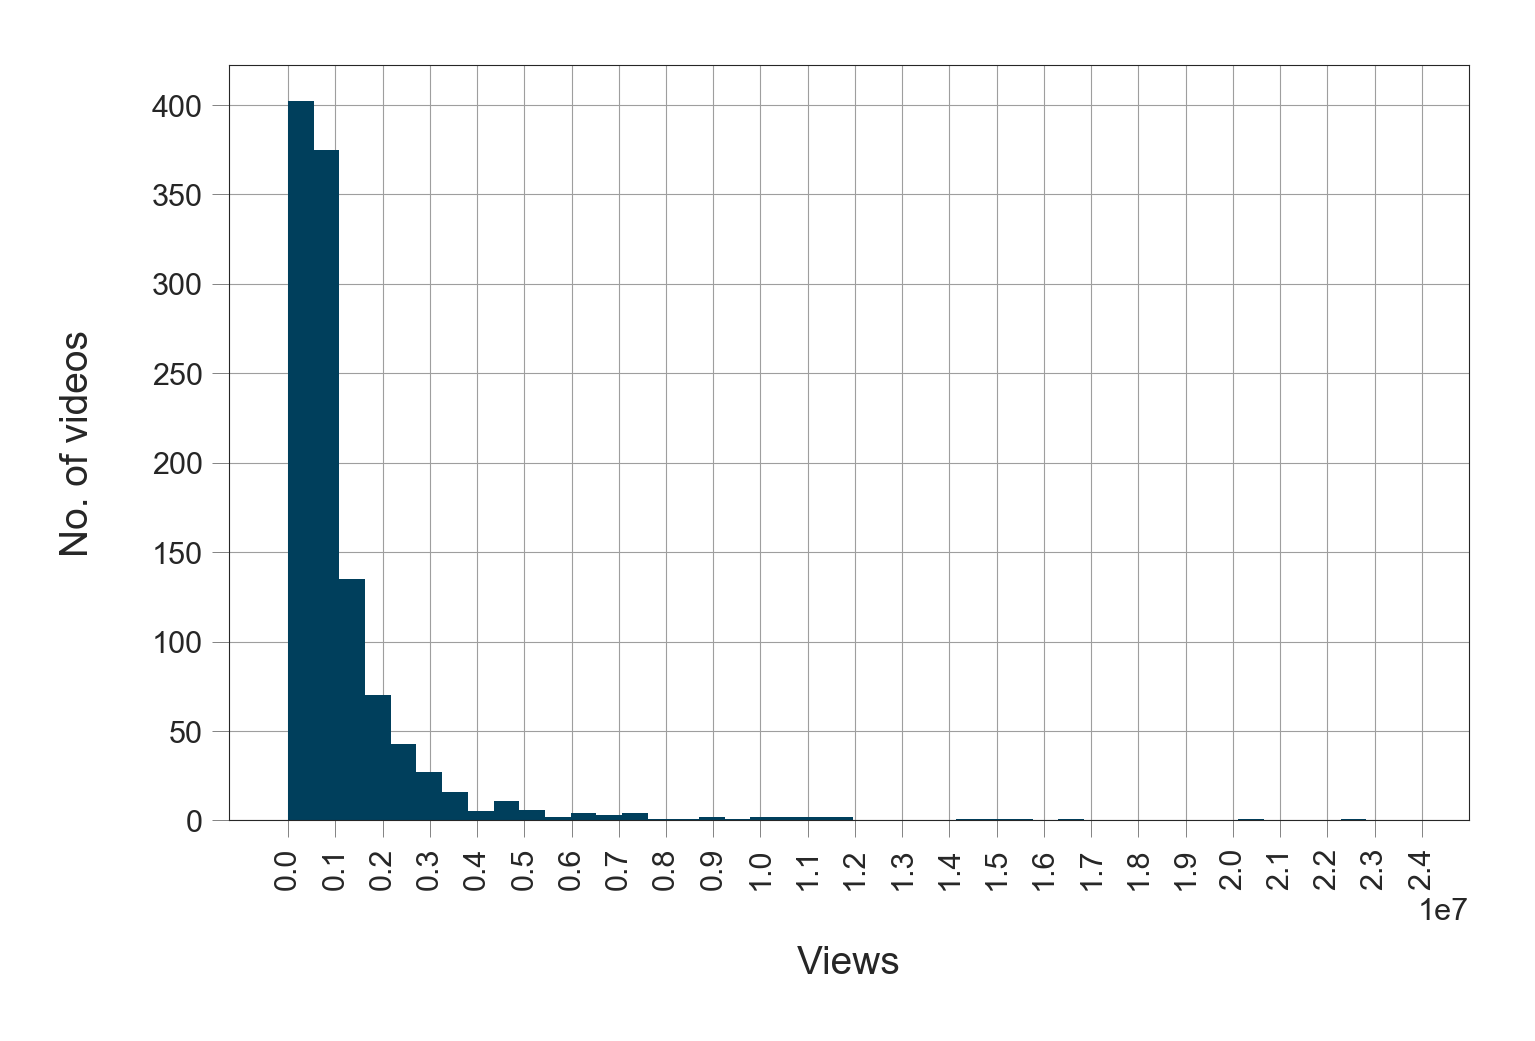

In [10]:
fig, ax = plt.subplots()
_ = sns.distplot(df["view_count"], kde=False, color=PLOT_COLORS[4], 
                 hist_kws={'alpha': 1}, bins=np.linspace(0, 2.5e7, 47), ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos", xticks=np.arange(0, 2.5e7, 1e6))
_ = ax.set_xlim(right=2.5e7)
_ = plt.xticks(rotation=90)

We note that the vast majority of trending videos have `5 million` views or less. We get the `5` million number by calculating

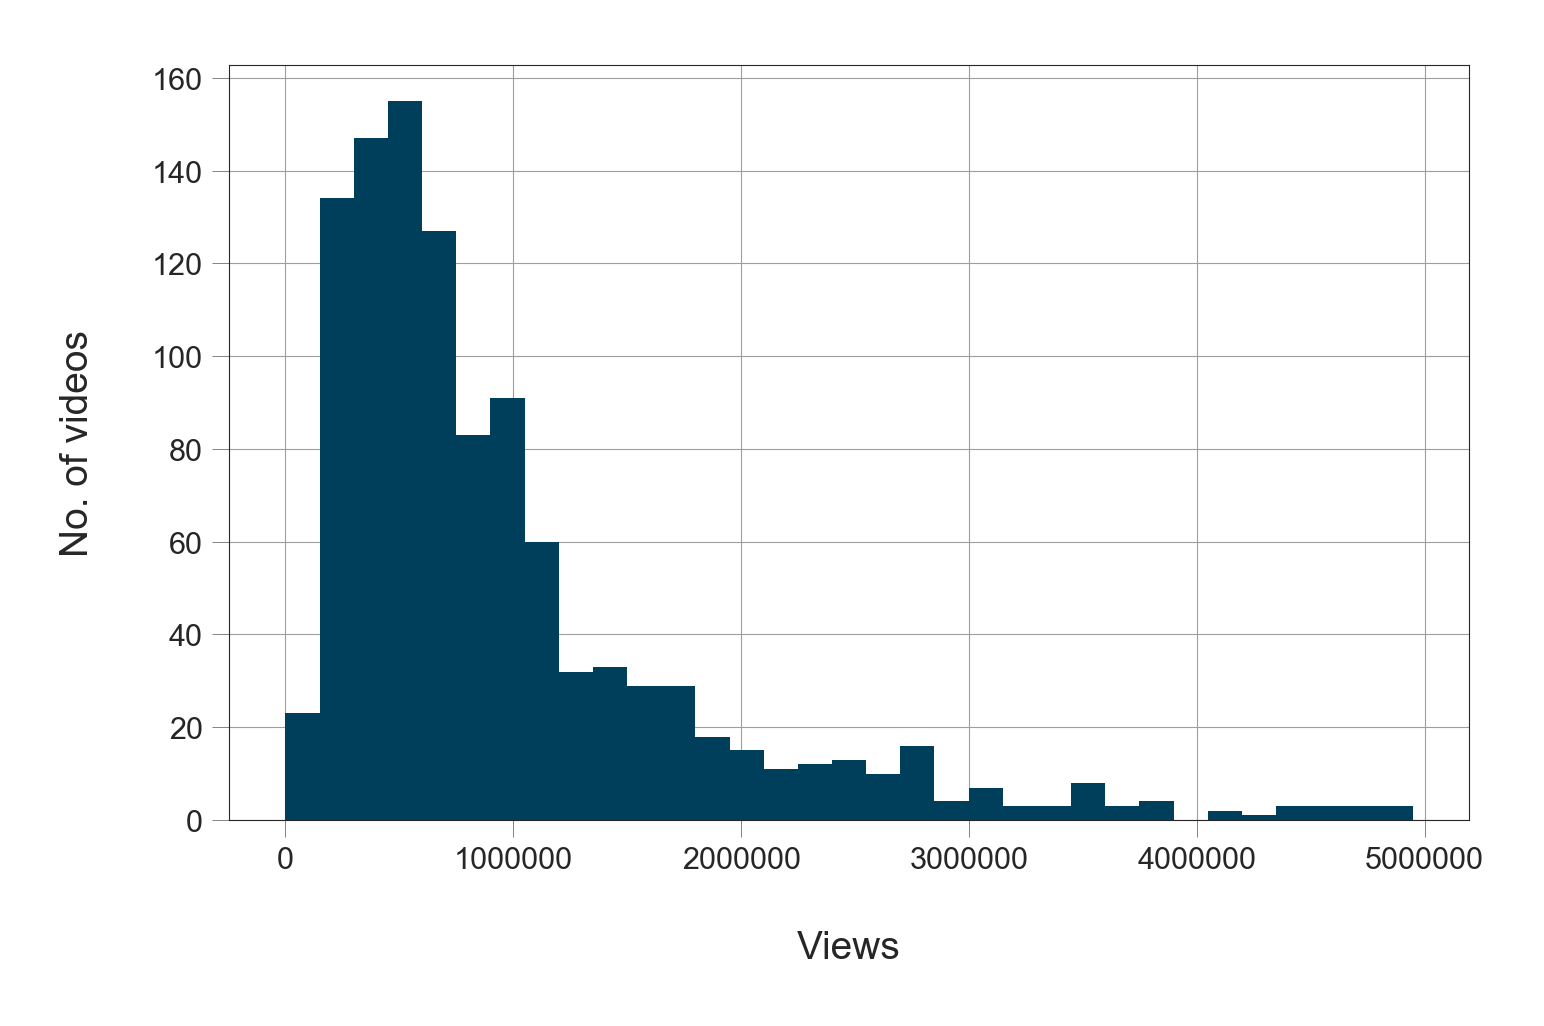

In [11]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["view_count"] < 5e6]["view_count"], kde=False, 
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos")

Now we see that the majority of trending videos have `2` million views or less. Let's see the exact percentage of videos less than `1` million views

In [12]:
df[df['view_count'] < 2e6]['view_count'].count() / df['view_count'].count() * 100

86.36363636363636

So, it is around `86%`. Similarly, we can see that the percentage of videos with less than `1.5` million views is around `78%`, and that the percentage of videos with less than `5` million views is around `96%`.

### <a name="lh"></a>Likes histogram

After `views`, we plot the histogram for `likes` column

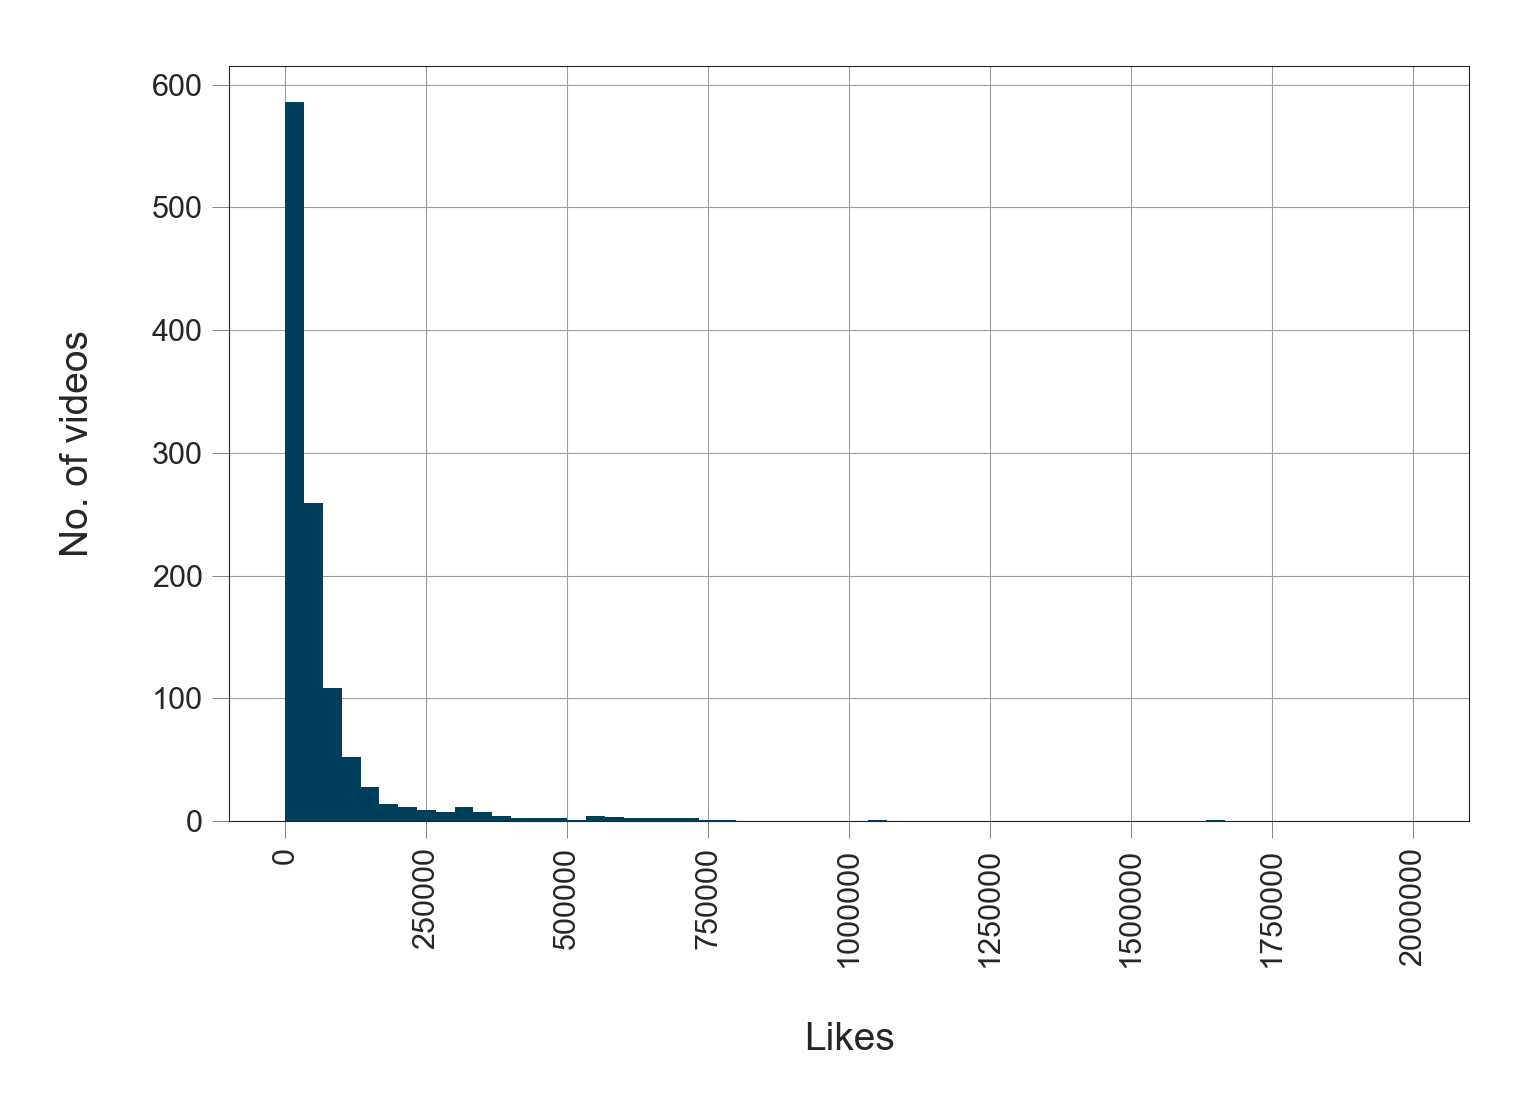

In [13]:
plt.rc('figure.subplot', wspace=0.9)
fig, ax = plt.subplots()
_ = sns.distplot(df["likes"], kde=False, 
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 2e6, 61), ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos")
_ = plt.xticks(rotation=90)

We note that the vast majority of trending videos have between `0` and `250,000` likes. Let us plot the histogram just for videos with `250,000` likes or less to get a closer look at the distribution of the data

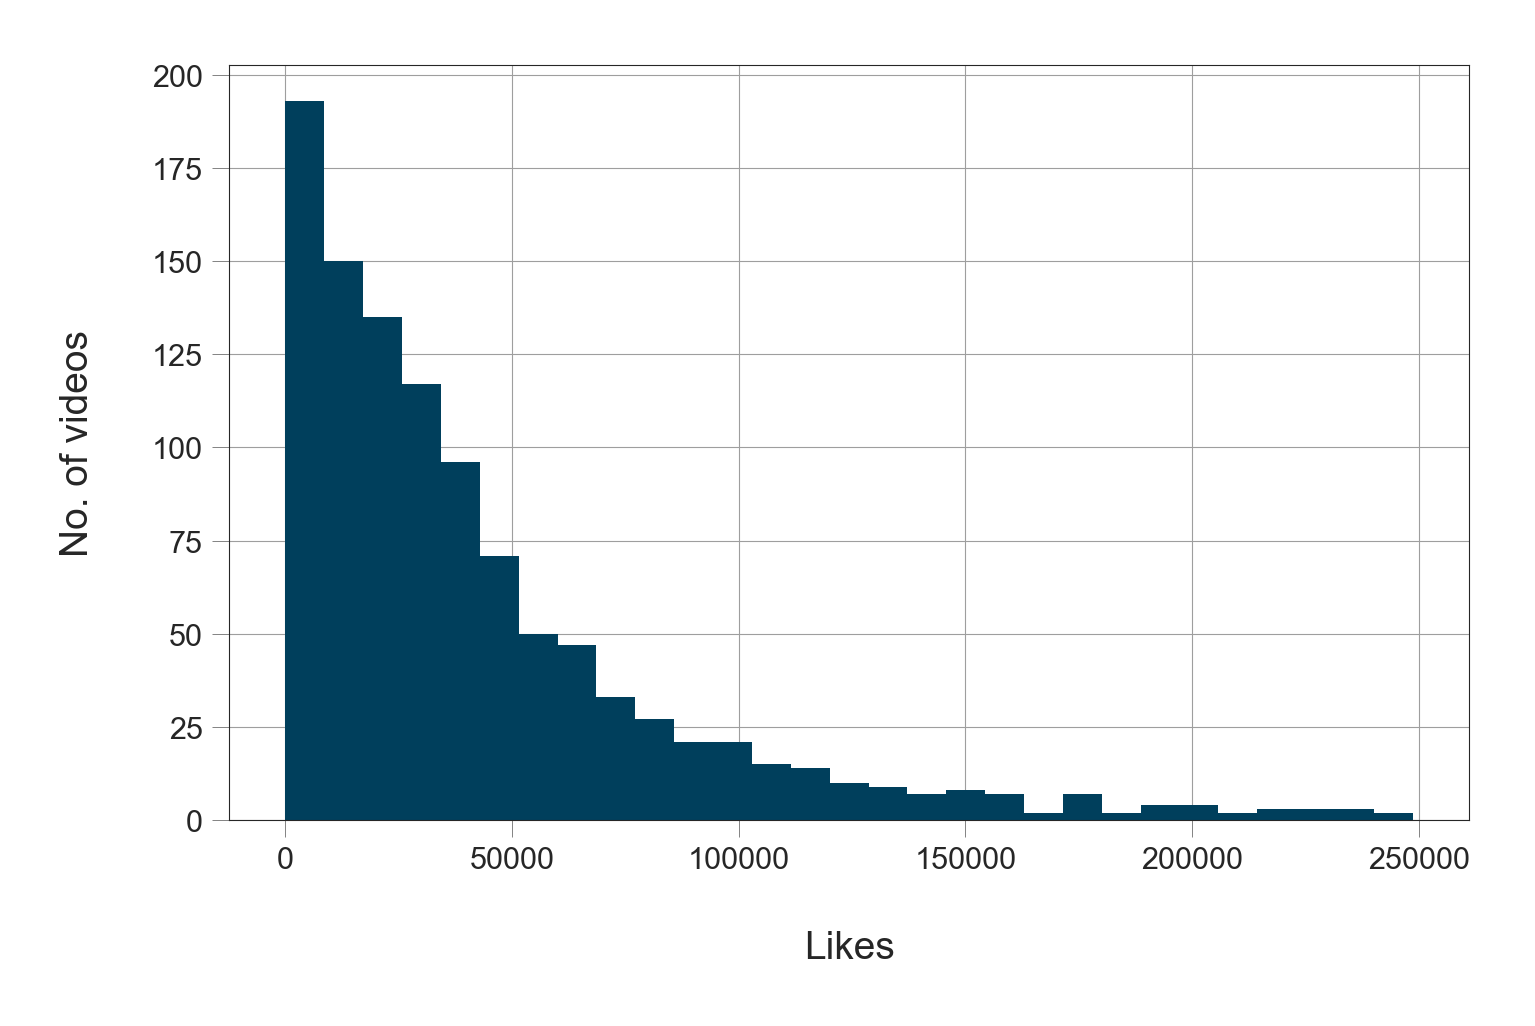

In [14]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["likes"] <= 25e4]["likes"], kde=False, 
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos")

Now we can see that the majority of videos have `100,000` likes or less. 

Let's see the exact percentage of videos with less than `50,000` likes 

In [15]:
df[df['likes'] < 5e4]['likes'].count() / df['likes'].count() * 100

67.29055258467022

Similarly, we can see that the percentage of videos with less than `100,000` likes is around `84%`

In [16]:
df[df['likes'] < 1e5]['likes'].count() / df['likes'].count() * 100

84.93761140819964

### <a name="ch"></a>Comment count histogram

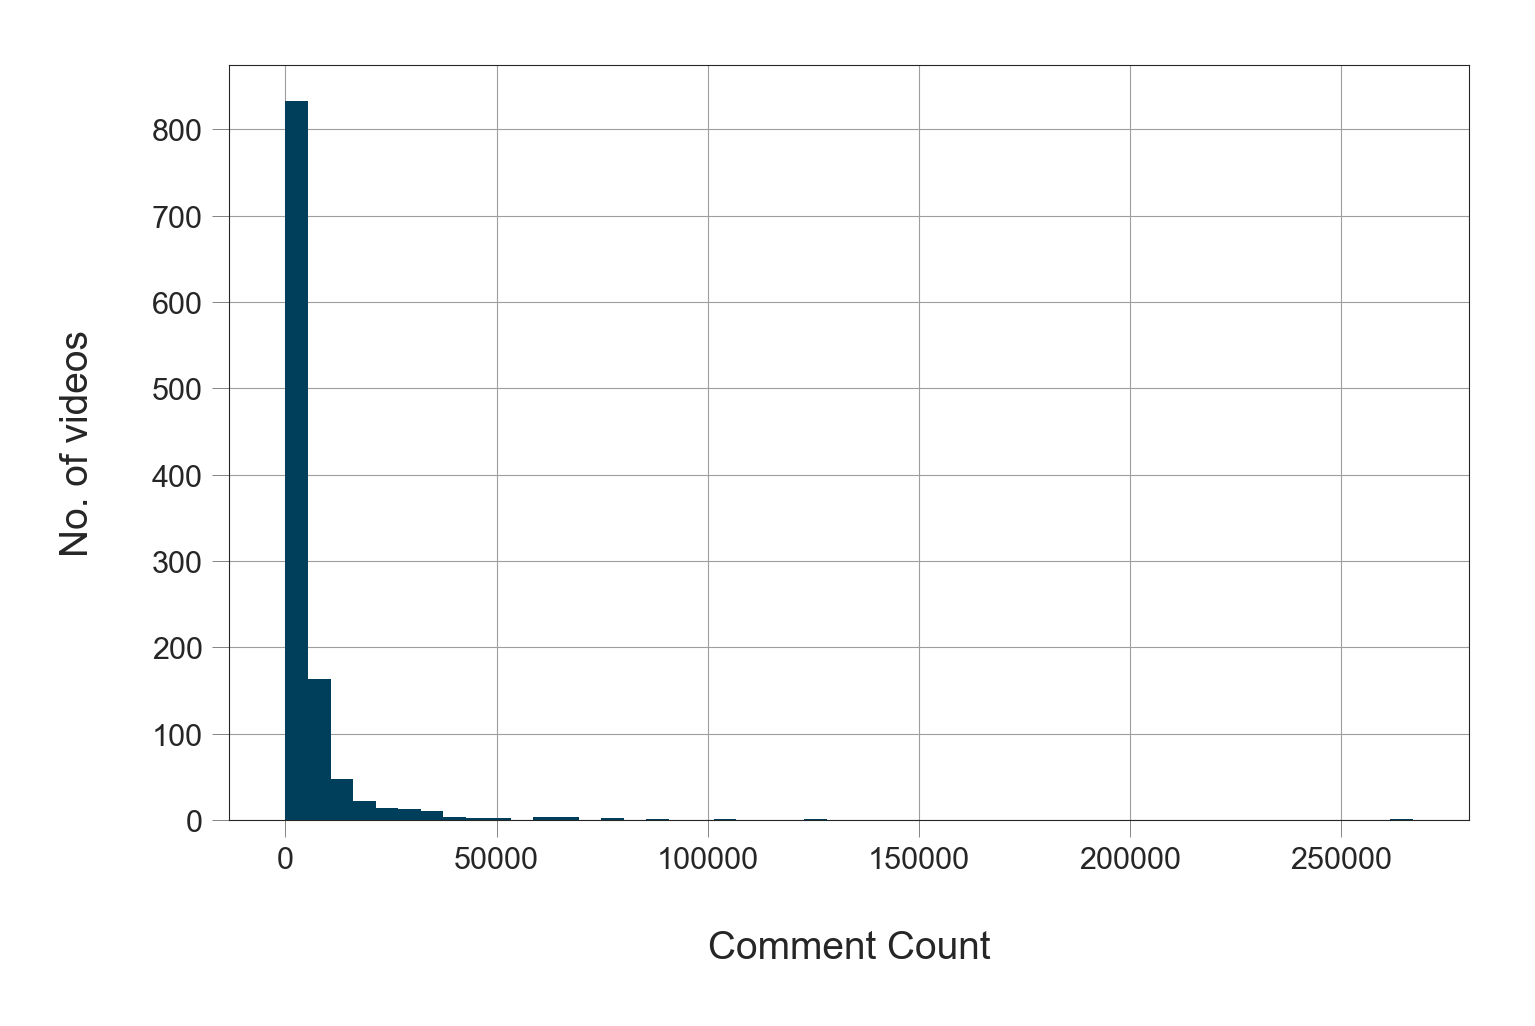

In [17]:
fig, ax = plt.subplots()
_ = sns.distplot(df["comment_count"], kde=False, rug=False, 
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Comment Count", ylabel="No. of videos")

Let's get a closer look by eliminating entries with comment count larger than `125,000` comments

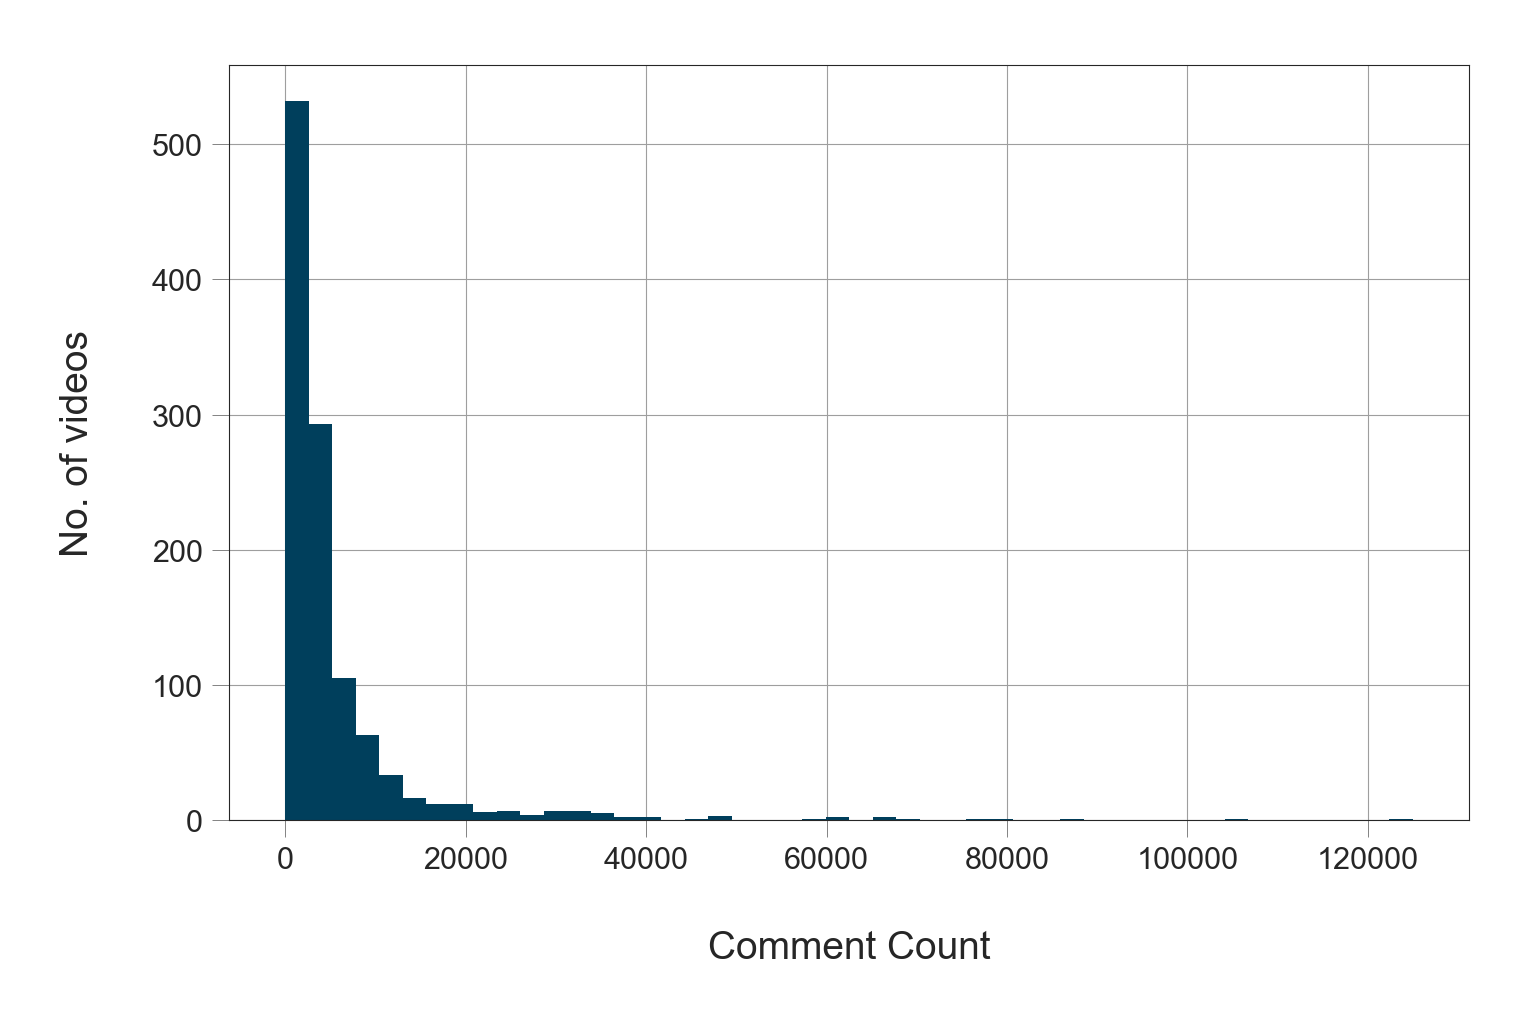

In [18]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["comment_count"] < 200000]["comment_count"], kde=False, rug=False, 
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 12.5e4, 49), ax=ax)
_ = ax.set(xlabel="Comment Count", ylabel="No. of videos")

We see that most trending videos have around

As with views and likes, let's see the exact percentage of videos with less than `4000` comments

In [19]:
df[df['comment_count'] < 4000]['comment_count'].count() / df['comment_count'].count() * 100

65.59714795008912

In a similar way, we can see that the percentage of videos with less than `25,000` comments  is around `96%`.

## <a name="chan"></a>Which channels have the largest number of trending videos?

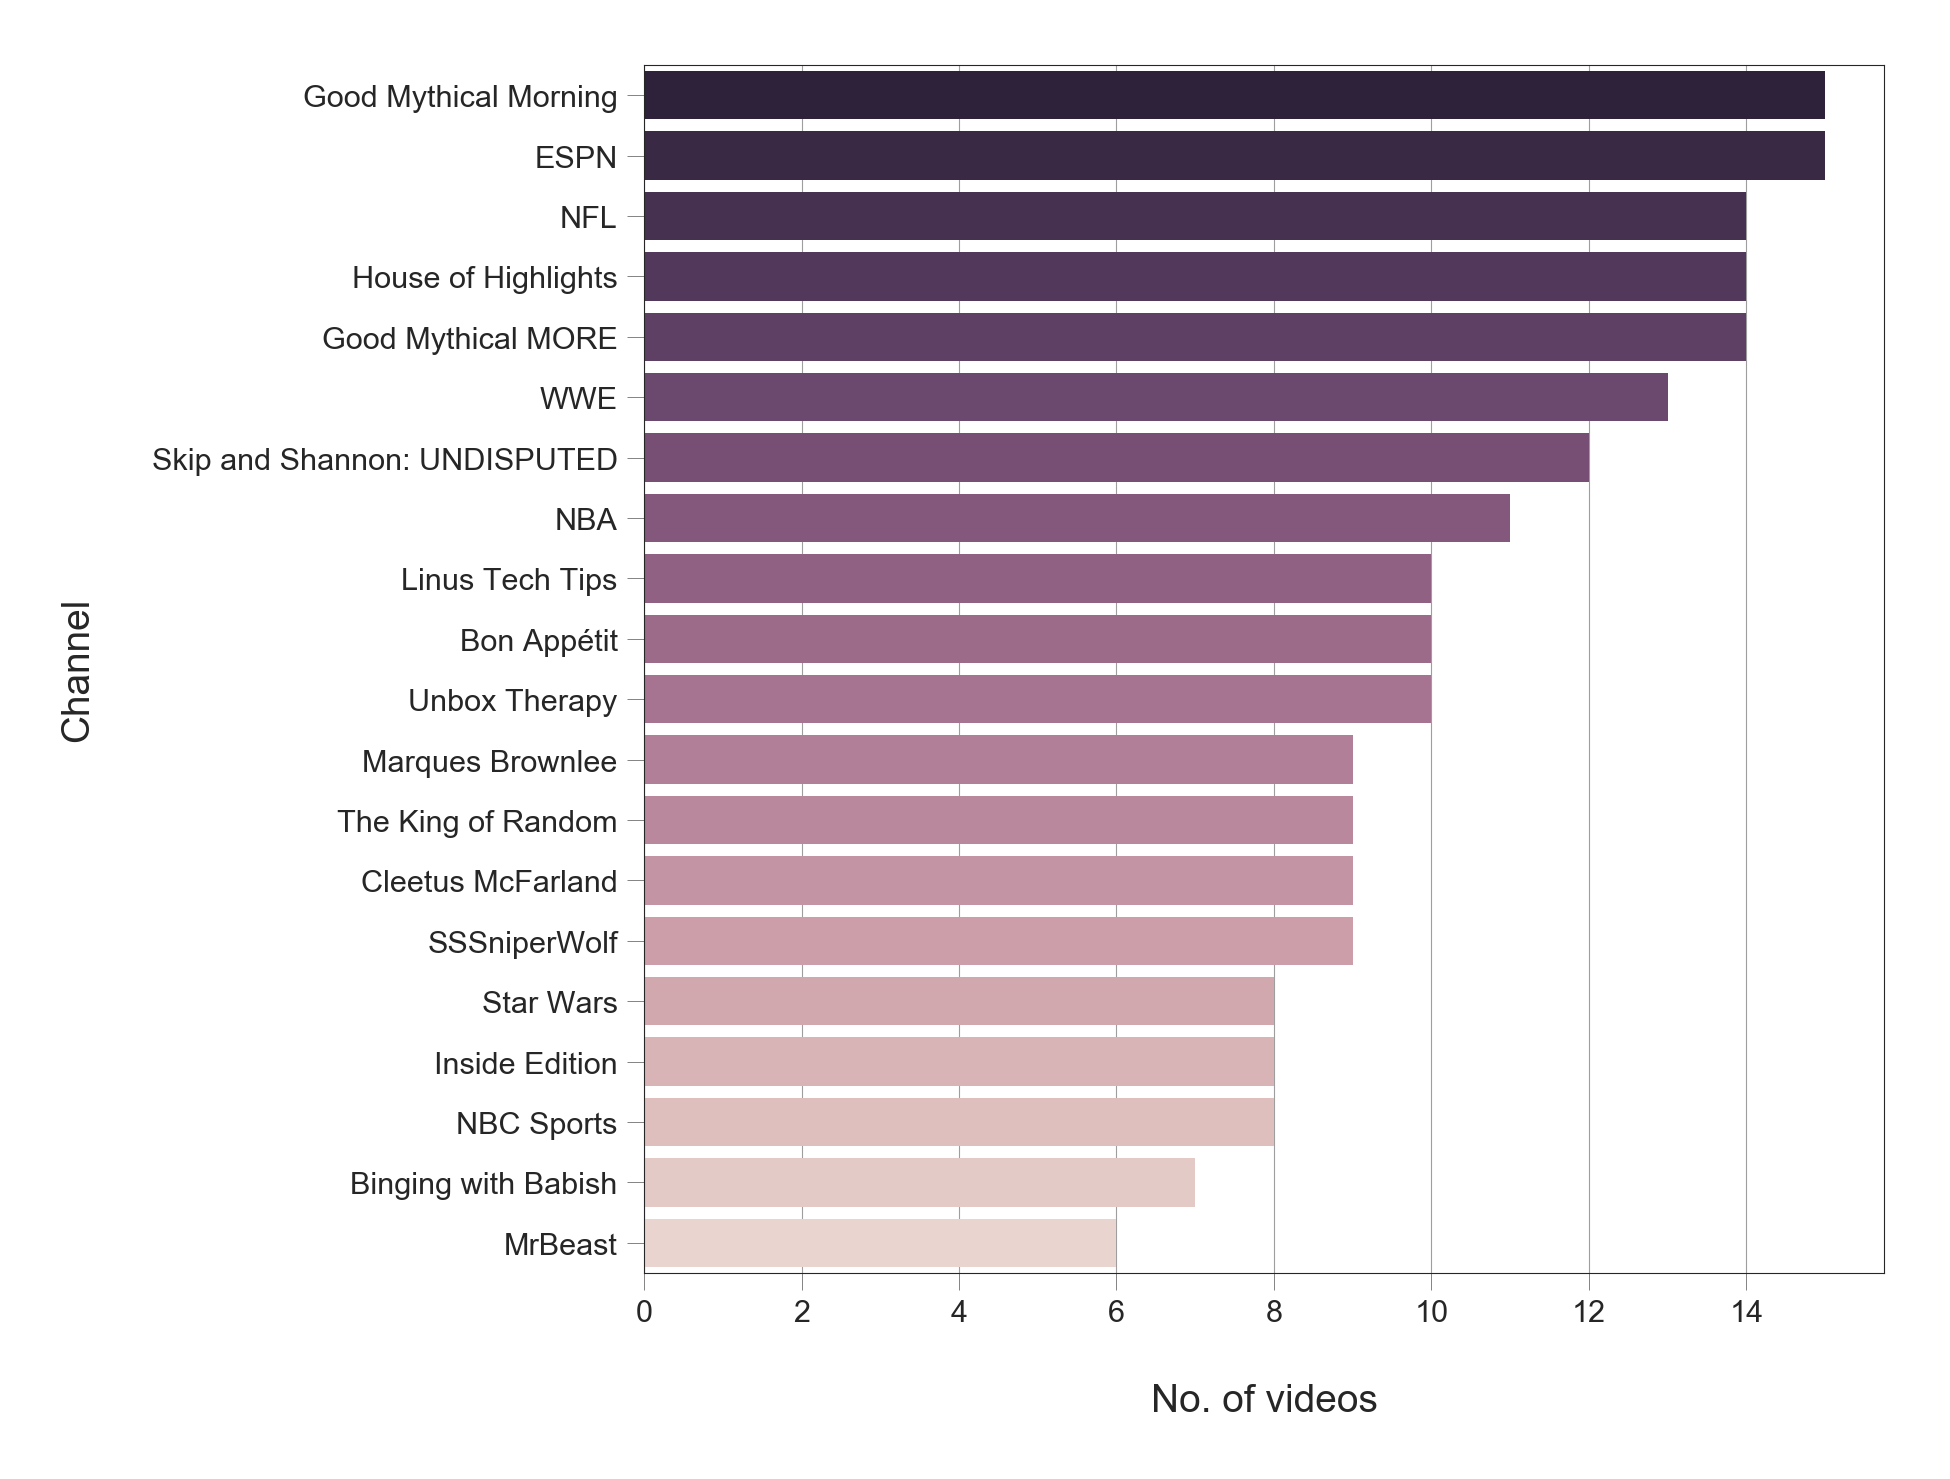

In [20]:
cdf = df.groupby("channel_title").size().reset_index(name="video_count") \
    .sort_values("video_count", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(8,8))
_ = sns.barplot(x="video_count", y="channel_title", data=cdf,
                palette=sns.cubehelix_palette(n_colors=20, reverse=True), ax=ax)
_ = ax.set(xlabel="No. of videos", ylabel="Channel")

## <a name="cat"></a>Which video category has the largest number of trending videos?
First, we will add a column that contains category names based on the values in `category_id` column. We will use a category JSON file provided with the dataset which contains information about each category.

In [21]:
with open('US_category_id.json') as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
df['category_name'] = df['category_id'].map(cat_dict)

Now we can see which category had the largest number of trending videos

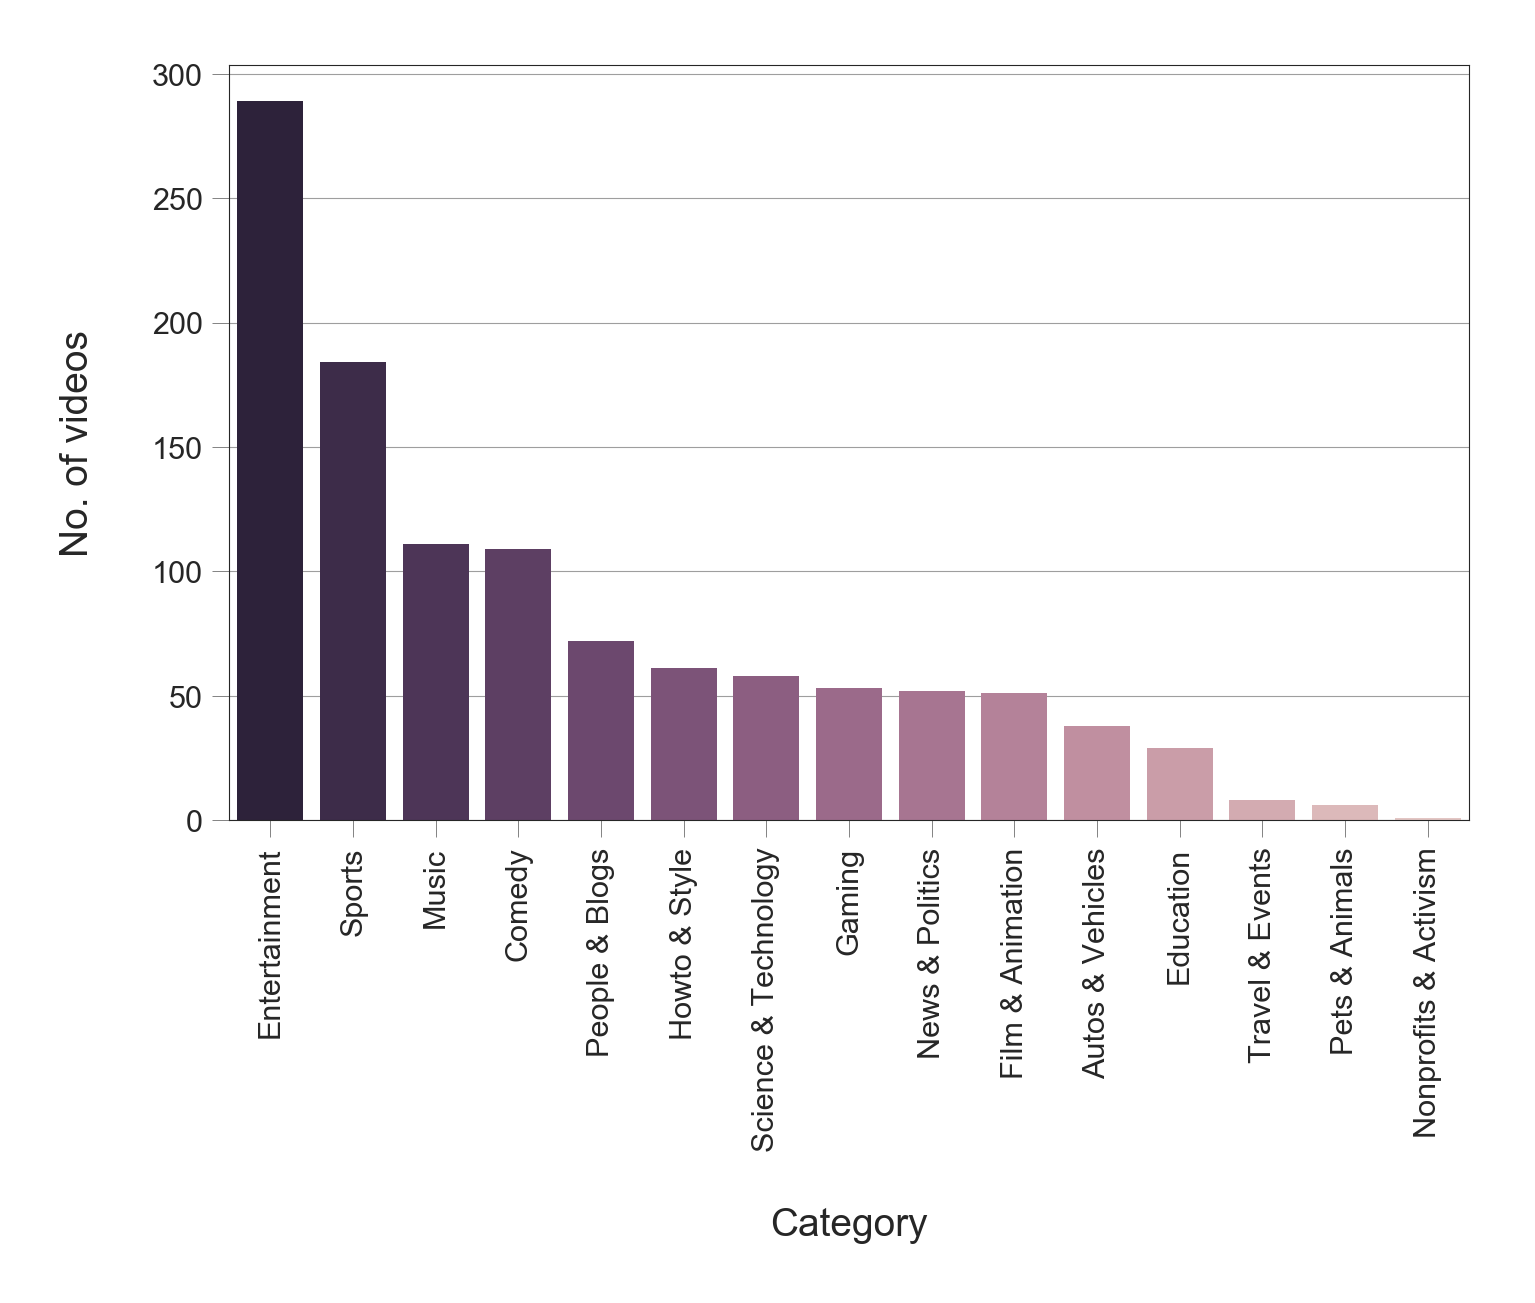

In [22]:
cdf = df["category_name"].value_counts().to_frame().reset_index()
cdf.rename(columns={"index": "category_name", "category_name": "No_of_videos"}, inplace=True)
fig, ax = plt.subplots()
_ = sns.barplot(x="category_name", y="No_of_videos", data=cdf, 
                palette=sns.cubehelix_palette(n_colors=16, reverse=True), ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel="Category", ylabel="No. of videos")

We see that the Entertainment category contains the largest number of trending videos among other categories: around `270` videos, followed by Sports category with around `170` videos, followed by Music category with around `110` videos, and so on.

## <a name="pub"></a>Trending videos and their publishing time
An example value of the `publish_time` column in our dataset is `2017-11-13T17:13:01.000Z`. And according to information on this page: https://www.w3.org/TR/NOTE-datetime, this means that the date of publishing the video is `2017-11-13` and the time is `17:13:01` in Coordinated Universal Time (UTC) time zone.

Let's add two columns to represent the date and hour of publishing each video, then delete the original `publish_time` column because we will not need it anymore

In [23]:
df["publishing_day"] = df["published_at"].apply(
    lambda x: datetime.strptime(x[:10], "%d-%m-%Y").date().strftime('%a'))
df["publishing_hour"] = df["published_at"].apply(lambda x: x[11:13])
#df.drop(labels='published_at', axis=1, inplace=True)

Now we can see which days of the week had the largest numbers of trending videos

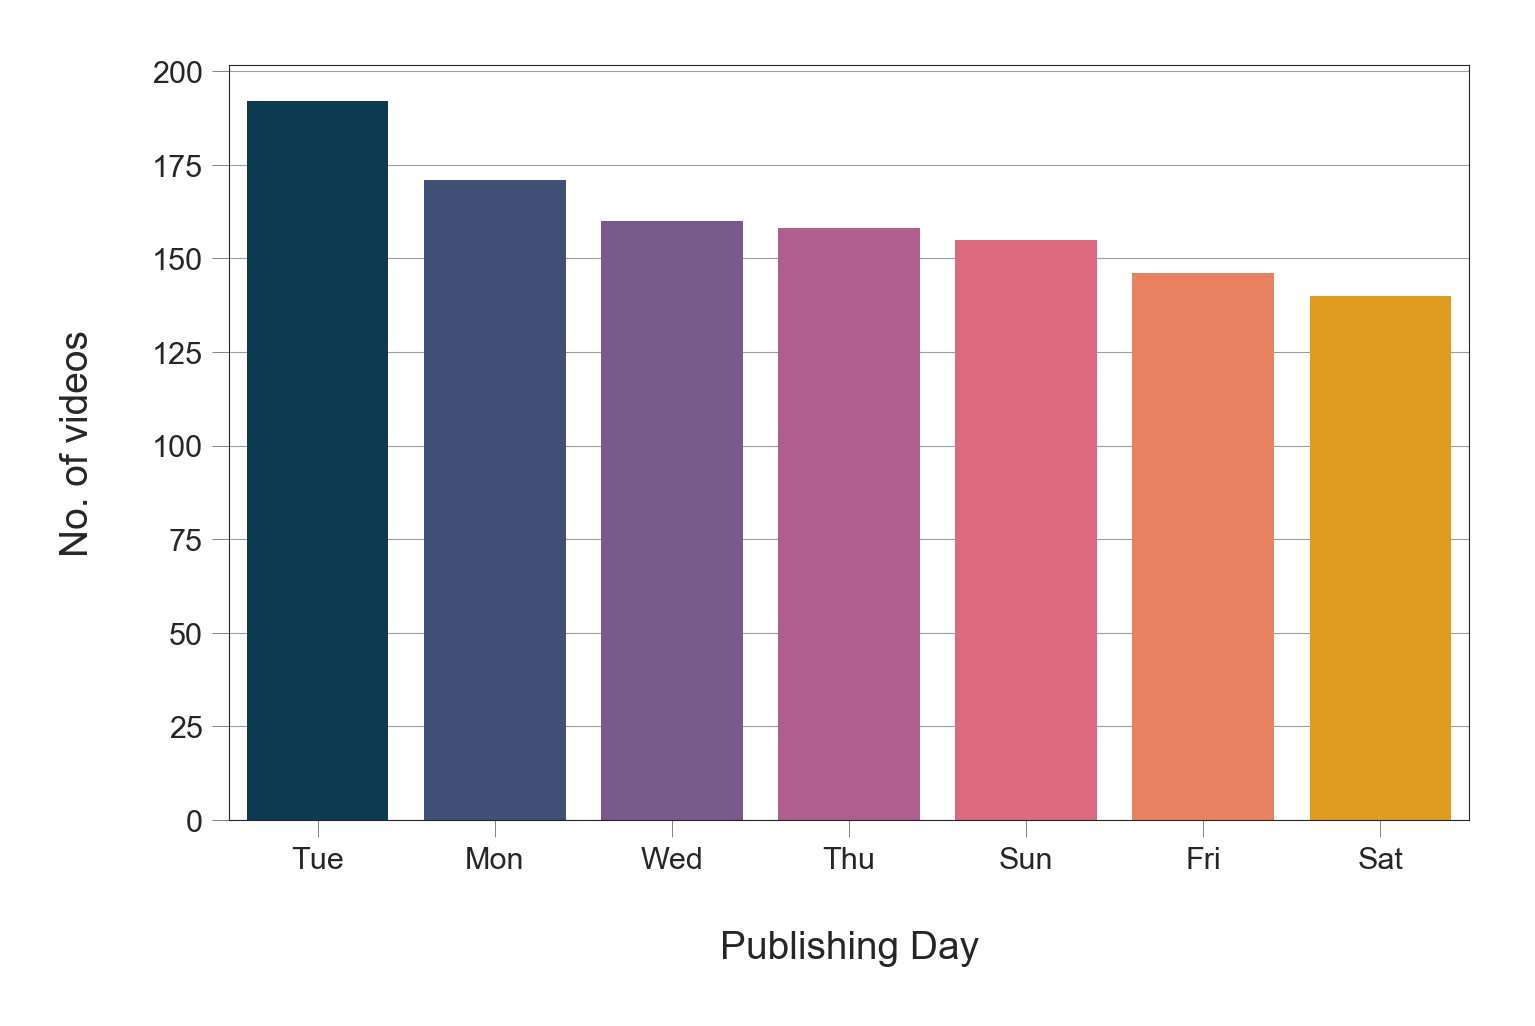

In [24]:
cdf = df["publishing_day"].value_counts()\
        .to_frame().reset_index().rename(columns={"index": "publishing_day", "publishing_day": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="publishing_day", y="No_of_videos", data=cdf, 
                palette=sns.color_palette(['#003f5c', '#374c80', '#7a5195', 
                                           '#bc5090', '#ef5675', '#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Publishing Day", ylabel="No. of videos")

We can see that the number of trending videos published on Sunday and Saturday are noticeably less than the number of trending videos published on other days of the week.

Now let's use `publishing_hour` column to see which publishing hours had the largest number of trending videos

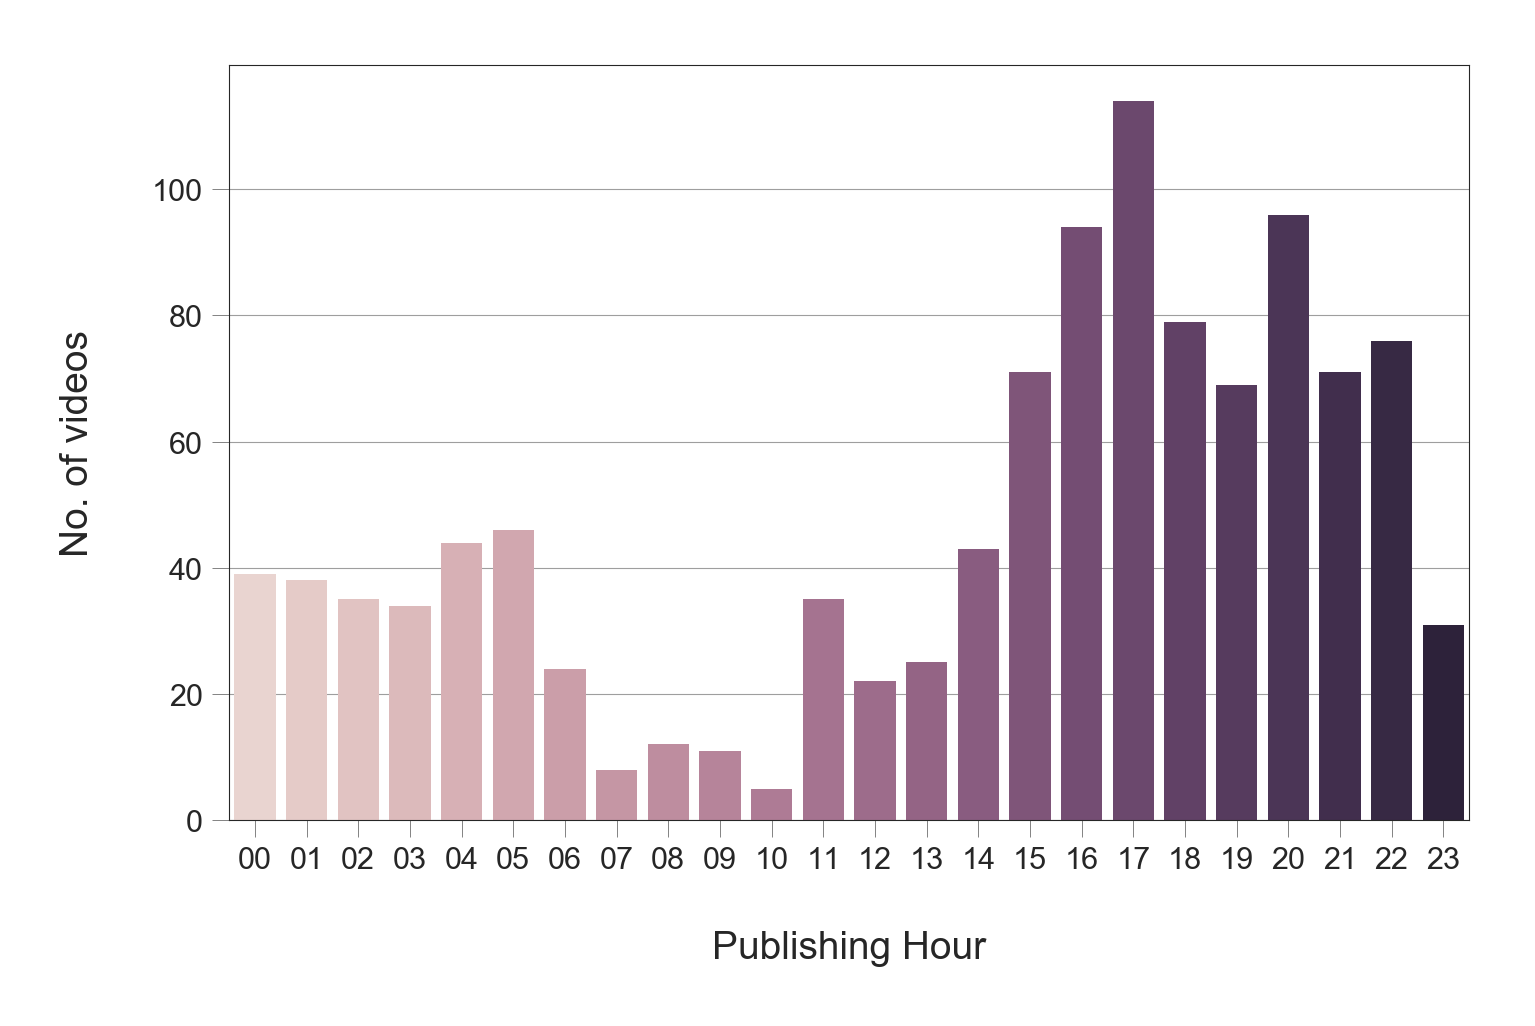

In [25]:
cdf = df["publishing_hour"].value_counts().to_frame().reset_index()\
        .rename(columns={"index": "publishing_hour", "publishing_hour": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="publishing_hour", y="No_of_videos", data=cdf, 
                palette=sns.cubehelix_palette(n_colors=24), ax=ax)
_ = ax.set(xlabel="Publishing Hour", ylabel="No. of videos")

We can see that the period between 2PM and 7PM, peaking between 4PM and 5PM, had the largest number of trending videos. We notice also that the period between 12AM and 1PM has the smallest number of trending videos.

## <a name="clean"></a>Data cleaning
The `description`(last column) ,`title` & `channel title`(non-trending data) columns have some null values. These are some of the rows whose description values are null. We can see that null values are denoted by `NaN`

In [26]:
df[df["description"].apply(lambda x: pd.isna(x))].sample(3)

,video_id,title,published_at,channel_id,channel_title,category_id,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,rating_disabled,description,category_name,publishing_day,publishing_hour
833,HAZ3fg5OTYU,6 Straight Women vs 1 Secret Lesbian,24-11-2019 15:00,UCJjSDX-jUChzOEyok9XYRJQ,Jubilee,24,25-11-2019 03:04,jubilee|jubilee media|jubilee project|live dee...,1460535,67361,1142,7603,https://i.ytimg.com/vi/HAZ3fg5OTYU/default.jpg,False,False,NaN,Entertainment,Sun,15
972,6hk9RvZ3JvA,'Raising Hell' & 'TiK ToK' | Live at the 2019 ...,27-11-2019 06:07,UC9HnKwLco0wfmmHJT4KOjJw,keshaVEVO,10,28-11-2019 03:04,Kesharose|kesha raising hell|high road|kesha h...,545691,42656,479,2196,https://i.ytimg.com/vi/6hk9RvZ3JvA/default.jpg,False,False,NaN,Music,Wed,06
220,QWGGtKgalDo,NaN,06-11-2019 14:10,UCFctpiB_Hnlk3ejWfHqSm6Q,The Official Pokémon YouTube channel,20,07-11-2019 12:30,Pokemon|Pokémon|Pokémon Sword Shield|Pokémon S...,524061,27250,2774,4826,https://i.ytimg.com/vi/QWGGtKgalDo/default.jpg,False,False,NaN,Gaming,Wed,14


In [27]:
df[df["title"].apply(lambda x: pd.isna(x))].head(3)

,video_id,title,published_at,channel_id,channel_title,category_id,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,rating_disabled,description,category_name,publishing_day,publishing_hour
140,SumDHcnCRuU,NaN,30-10-2019 11:15,UC2C_jShtL725hvbm1arSV9w,CGP Grey,27,05-11-2019 01:00,cgpgrey|education|space|earth|venus|mars|mercu...,1379986,98654,1024,5997,https://i.ytimg.com/vi/SumDHcnCRuU/default.jpg,False,False,"Thank you, my patrons, for making this video p...",Education,Wed,11
177,euy4UaYJXzY,NaN,29-10-2019 12:24,UCHu2KNu6TtJ0p4hpSW7Yv7Q,Jazza,24,05-11-2019 01:00,josiah|brooks|jazza|jazzastudios|animation|new...,898741,34985,738,4479,https://i.ytimg.com/vi/euy4UaYJXzY/default.jpg,False,False,"➨ Get my APP, Courses, eBooks, Brushes and mor...",Entertainment,Tue,12
220,QWGGtKgalDo,NaN,06-11-2019 14:10,UCFctpiB_Hnlk3ejWfHqSm6Q,The Official Pokémon YouTube channel,20,07-11-2019 12:30,Pokemon|Pokémon|Pokémon Sword Shield|Pokémon S...,524061,27250,2774,4826,https://i.ytimg.com/vi/QWGGtKgalDo/default.jpg,False,False,NaN,Gaming,Wed,14


So to do some sort of data cleaning, and to get rid of those null values, we put an empty string in place of each null value in the `description`, `title` & `Channel Title` column

In [28]:
df["description"] = df["description"].fillna(value="")
df["title"] = df["title"].fillna(value="")
non_df["description"] = df["description"].fillna(value="")
non_df["title"] = df["title"].fillna(value="")
non_df["channel_title"] = non_df["channel_title"].fillna(value="")

Remove 1st 200 data points since they were already on the trending section when the above script ran for the 1st time and hence we cannot determine the exact time they were added to the section

In [29]:
df = df[200:]

Here we remove the data points which have view count zero for trending videos 

In [30]:
df = df[df.view_count != 0]

### Labeling and Merging dataframes

Now we label the two dataframes **df** and **non_df** which contains the **trending** and **Non-Trending** video data respectively as one and zero and then we merge the dataframes

In [31]:
df["label"] = 1
non_df["label"] = 0

Now we merge both the dataframes

In [32]:
df = pd.concat([df,non_df])

### Invalid Data
In the dataset collected there are 8 data points where the date when a video was published comes after the date when the video was promoted to trending section. This is not logically possible and hence we exclude such data points. 

Let us convert the **trending_date** and **published_at** strings to datetime objects to better understand and process the data

In [33]:
df["published_at"] = pd.to_datetime(df["published_at"],format = '%d-%m-%Y %H:%M',exact = True,infer_datetime_format=False)
df["trending_date"] = pd.to_datetime(df["trending_date"],format = '%d-%m-%Y %H:%M',exact = True,infer_datetime_format=False)
df.dtypes

category_id                   int64
category_name                object
channel_id                   object
channel_title                object
comment_count                 int64
comments_disabled              bool
description                  object
dislikes                      int64
label                         int64
likes                         int64
published_at         datetime64[ns]
publishing_day               object
publishing_hour              object
rating_disabled                bool
tags                         object
thumbnail_link               object
title                        object
trending_date        datetime64[ns]
video_id                     object
view_count                    int64
dtype: object

In [34]:
df_sample = df[df.trending_date < df.published_at]
df_sample

,category_id,category_name,channel_id,channel_title,comment_count,comments_disabled,description,dislikes,label,likes,published_at,publishing_day,publishing_hour,rating_disabled,tags,thumbnail_link,title,trending_date,video_id,view_count
280,1,Film & Animation,UC_IRYSp4auq7hKLvziWVH6w,Pixar,3072,False,"Next summer, Joe Gardner will discover his bri...",640,1,44179,2019-11-07 13:53:00,Thu,13,False,Pixar|Disney|Disney Pixar|Pixar Movie|Animation,https://i.ytimg.com/vi/4TojlZYqPUo/default.jpg,Soul | Official Teaser Trailer,2019-11-07 13:17:00,4TojlZYqPUo,358392
294,28,Science & Technology,UCXuqSBlHAE6Xw-yeJA0Tunw,Linus Tech Tips,1429,False,Get yourself a dbrand skin at https://dbrand.c...,549,1,16784,2019-11-07 19:41:00,Thu,19,False,Apple|Airpods pro|review|Airpods|Pro|Apple Air...,https://i.ytimg.com/vi/XziVC8YUE5M/default.jpg,Sometimes Apple just does it better - AirPods ...,2019-11-07 18:43:00,XziVC8YUE5M,155925
295,22,People & Blogs,UCbAwSkqJ1W_Eg7wr3cp5BUA,Safiya Nygaard,6301,False,So a few months ago when Cristine was in Los A...,323,1,54149,2019-11-07 21:00:00,Thu,21,False,mixing custom nail polish colors|making custom...,https://i.ytimg.com/vi/UoSSCUMk-7I/default.jpg,Making Custom Nail Polish Colors feat. Simply ...,2019-11-07 18:43:00,UoSSCUMk-7I,380800
1098,24,Entertainment,UCSAUGyc_xA8uYzaIVG6MESQ,nigahiga,3078,False,Leave your dear ryan's in the comments for the...,113,1,34443,2019-12-01 21:16:00,Sun,21,False,ryan|higa|higatv|nigahiga|epic mime fight|dear...,https://i.ytimg.com/vi/CRTQUacD1GA/default.jpg,Epic Mime Fight! (Dear Ryan),2019-12-01 20:23:00,CRTQUacD1GA,257095
1105,24,Entertainment,UCITqR49EAUY8i1vZtXTwe-A,Dolan Twins,6015,False,Here is our Van Tour! We built a fully custom ...,487,1,97188,2019-12-01 21:03:00,Sun,21,False,Dolan|Twins|Van tour|livable van|custom van|li...,https://i.ytimg.com/vi/zGwrBIscb24/default.jpg,VAN TOUR | Custom Built For Twins To Live In,2019-12-01 20:59:00,zGwrBIscb24,674102
1106,17,Sports,UCDVYQ4Zhbm3S2dlz7P1GBDg,NFL,4937,False,The San Francisco 49ers take on the Baltimore ...,378,1,10275,2019-12-01 21:14:00,Sun,21,False,NFL|Football|offense|defense|American Football...,https://i.ytimg.com/vi/j-ryInG6ErA/default.jpg,49ers vs. Ravens Week 13 Highlights | NFL 2019,2019-12-01 20:59:00,j-ryInG6ErA,479371
1120,1,Film & Animation,UCwTkM6CvIsYFaFiMKIKCqHw,James Bond 007,322,False,Bond is back. The first trailer for NO TIME TO...,38,1,2134,2019-12-02 01:20:00,Mon,01,False,James Bond|Daniel Craig|No Time To Die|Bond25|...,https://i.ytimg.com/vi/QMrGxC60vzk/default.jpg,NO TIME TO DIE Teaser,2019-12-01 22:53:00,QMrGxC60vzk,19521
190,26,NaN,UCSC_8gNeqj7hVDSPRzTc9_A,CNNArabic,0,False,"SUBSCRIBE TODAY SO I CAN BEAT PEWDIEPIE TO 1,0...",1,0,7,2019-12-01 20:15:00,NaN,NaN,False,CNN|CNNArabic|cnnarabia|الشاب الإماراتي سعيد ا...,https://i.ytimg.com/vi/VK8OngAUX74/default.jpg,"My 1,200HP Built LLY DURAMAX IS BACK And I Bou...",2019-12-01 19:53:00,VK8OngAUX74,248
416,25,NaN,UC0M-_02RJqMlGTKUjF1WhJg,가로세로연구소,145,False,"Fabinho, Mohamed Salah and Sadio Mane all foun...",224,0,11801,2019-12-03 01:32:00,NaN,NaN,False,[none],https://i.ytimg.com/vi/JrSzQSxyNrg/default.jpg,Liverpool v. Manchester City | PREMIER LEAGUE ...,2019-12-02 21:36:00,JrSzQSxyNrg,84126


Now we remove these data points

In [35]:
df = df[df.trending_date > df.published_at]

Let us now see the time difference between time when video went on trending and the time when the video was published 

In [36]:
df["time_diff"] = (df["trending_date"] - df["published_at"])
diff_hr = df["time_diff"] / np.timedelta64(1,'h')
df = df.assign(diff_hr = diff_hr )

In [37]:
df["diff_hr"].head(5)

200   22.67
201   14.50
202   14.18
203   42.13
204   20.50
Name: diff_hr, dtype: float64

### Binary Classification

Since our data has only two distinct classes, we will use a binary classifier on our dataset.
Let us plot the Time difference vs View count plot of the merged dataframes to gain insights on how the data is distributed

In [38]:
df[(df.label == 1) & (df.diff_hr == 0)]
df = df[df.diff_hr < 400]

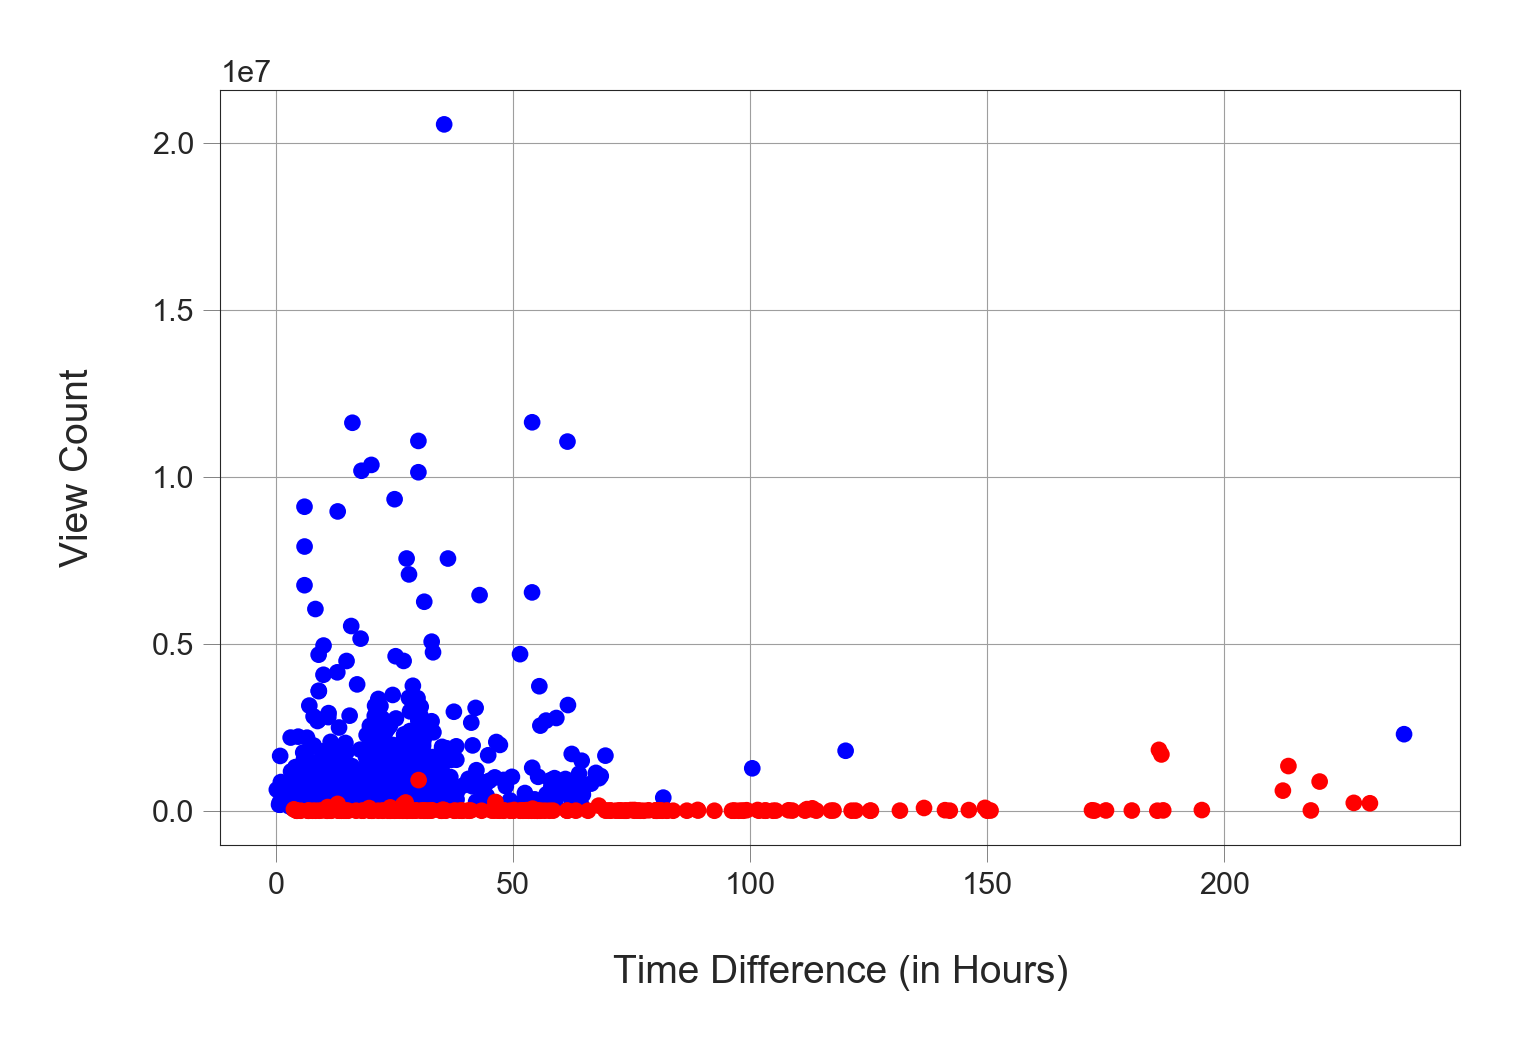

In [39]:
_ = matplotlib.pyplot.scatter(df["diff_hr"],df["view_count"],c=np.asarray(df["label"]),cmap=matplotlib.colors.ListedColormap(['red','blue']))
_ = matplotlib.pyplot.xlabel("Time Difference (in Hours)")
_ = matplotlib.pyplot.ylabel("View Count")

### Scaling the data

We need to scale the data because is has values which are high in magnitude, which may interfere with our results when we will use a classifier to classify the videos into trending and non trending.

In [40]:
from sklearn.preprocessing import RobustScaler
X = df[['view_count','likes','dislikes','diff_hr']].values
y = df["label"]
print(X)
trans = RobustScaler().fit(X)
X_fit = trans.transform(X)
#print(X[:,0])

[[1.34054400e+06 4.64000000e+04 2.31900000e+03 2.26666667e+01]
 [8.78750000e+05 4.00640000e+04 5.40000000e+02 1.45000000e+01]
 [3.11470000e+05 4.69400000e+03 1.33000000e+02 1.41833333e+01]
 ...
 [4.38000000e+02 5.00000000e+00 3.00000000e+00 1.04833333e+02]
 [2.19000000e+02 0.00000000e+00 0.00000000e+00 3.48666667e+01]
 [6.06000000e+02 1.00000000e+00 1.00000000e+00 8.01833333e+01]]


### Scaled Time Difference V/s View Count   

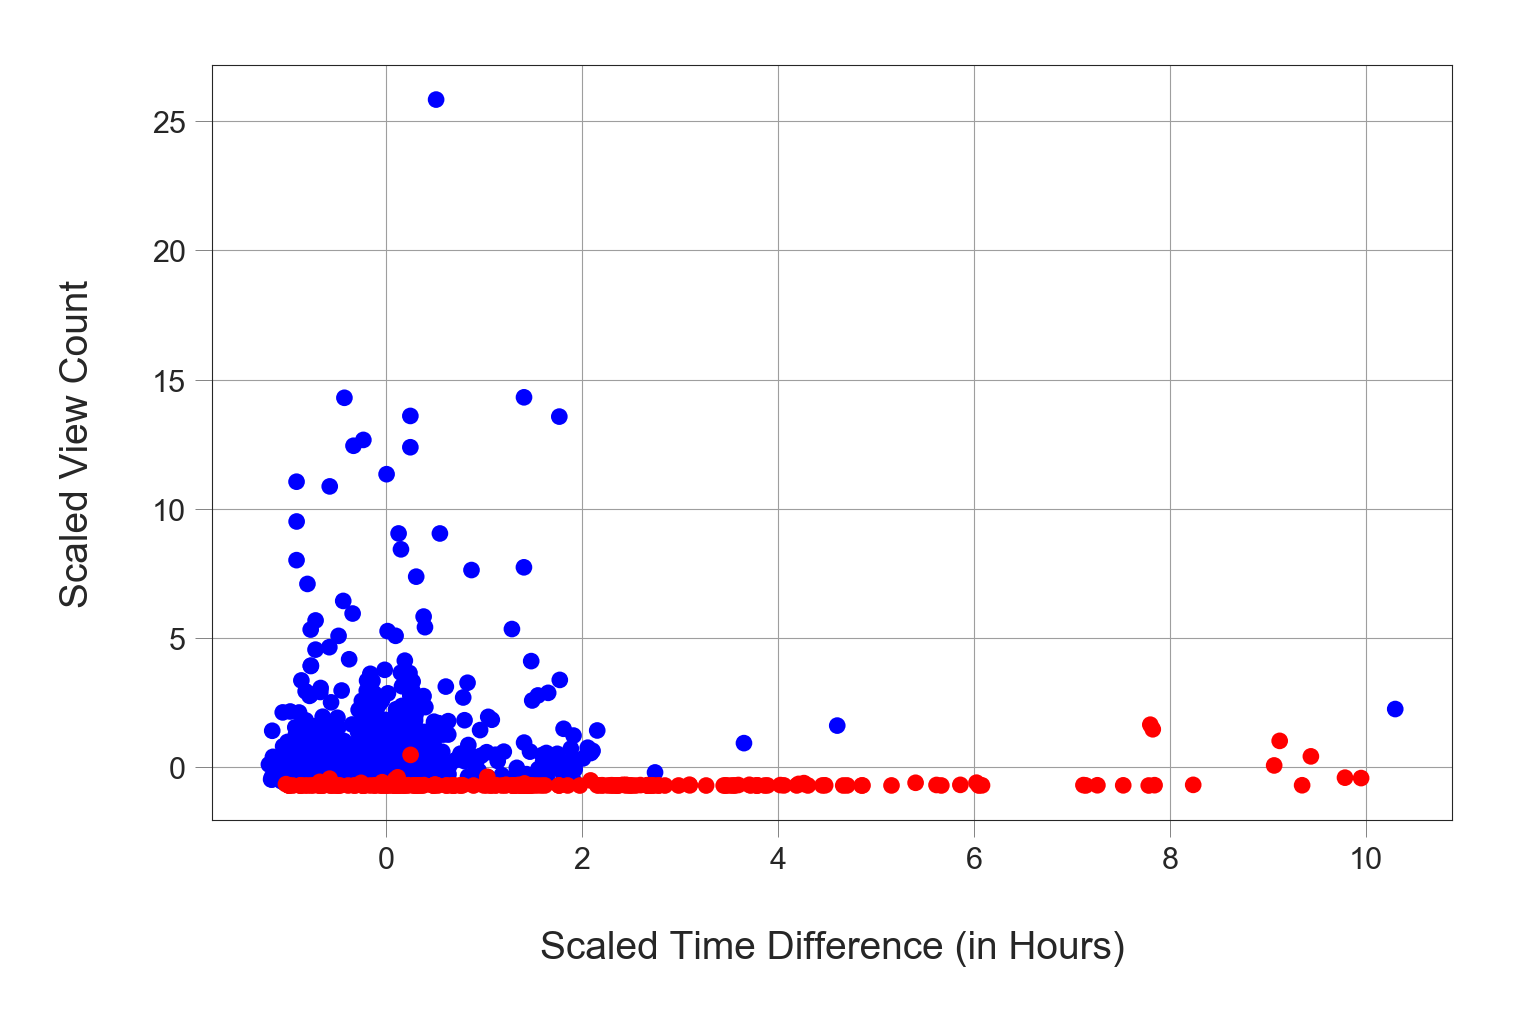

In [41]:
_ = matplotlib.pyplot.scatter(X_fit[:,3],X_fit[:,0],c=np.asarray(y),cmap=matplotlib.colors.ListedColormap(['red','blue']))
_ = matplotlib.pyplot.xlabel("Scaled Time Difference (in Hours)")
_ = matplotlib.pyplot.ylabel("Scaled View Count")

### Scaled Time Difference V/s Like

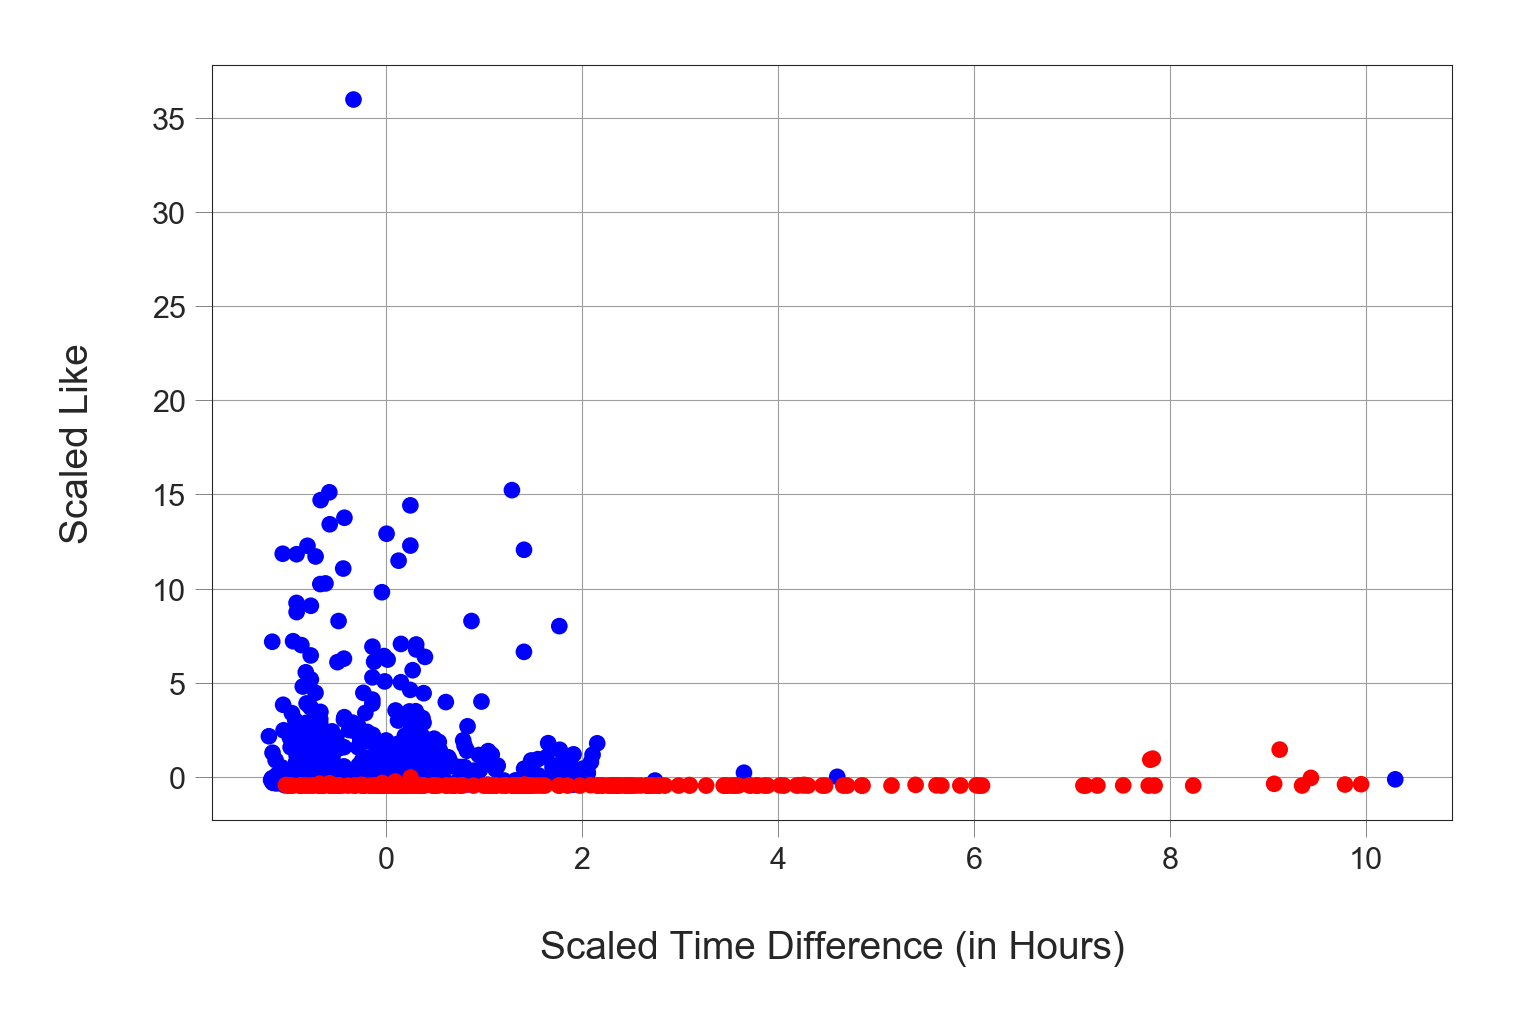

In [42]:
_ = matplotlib.pyplot.scatter(X_fit[:,3],X_fit[:,1],c=np.asarray(y),cmap=matplotlib.colors.ListedColormap(['red','blue']))
_ = matplotlib.pyplot.xlabel("Scaled Time Difference (in Hours)")
_ = matplotlib.pyplot.ylabel("Scaled Like")

## Ratio of View count and Time Difference (in Hours)

In [43]:
df_temp = df["view_count"]

In [44]:
df_temp.head(5)

200    1340544
201     878750
202     311470
203    3080069
204    1435870
Name: view_count, dtype: int64

In [45]:
df_temp = df_temp.astype("float64")

In [46]:
df["ratio"] = df["view_count"] / df["diff_hr"]

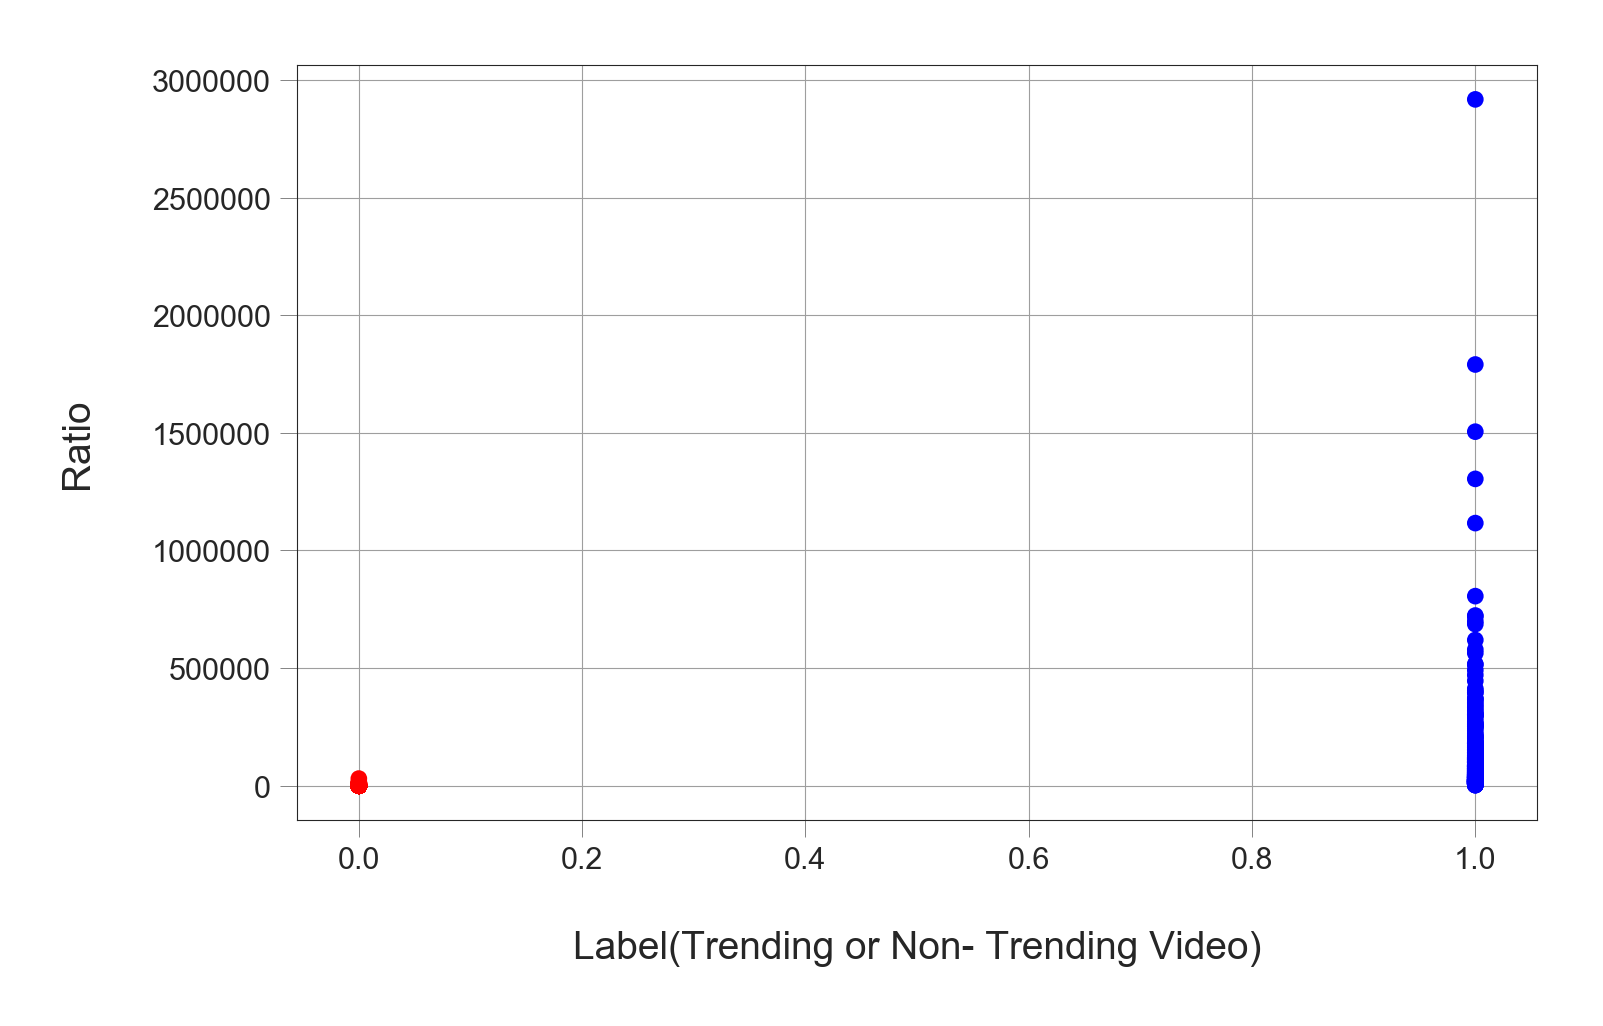

In [47]:
_ = matplotlib.pyplot.scatter(y,df["ratio"],c=np.asarray(y),cmap=matplotlib.colors.ListedColormap(['red','blue']))
_ = matplotlib.pyplot.ylabel("Ratio")
_ = matplotlib.pyplot.xlabel("Label(Trending or Non- Trending Video)")

As we can see that the ratio has a higher magnitude for trending videos as they have high view count and low time difference between trending time and publish time.

In [48]:
# Before imputing the data

In [49]:
df[df.label == 0 ]["ratio"].describe()

count     215.00
mean      695.04
std      2853.77
min         0.35
25%        13.79
50%        31.80
75%       101.71
max     30491.56
Name: ratio, dtype: float64

In [50]:
df[df.label == 1 ]["ratio"].describe()

count       913.00
mean      72516.31
std      160203.48
min        2635.00
25%       18206.66
50%       33645.83
75%       73102.90
max     2917583.08
Name: ratio, dtype: float64

Now let us split the dataset into training and testset.

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix

In [52]:
from imblearn.over_sampling import SMOTE
#resampling need to be done on training dataset only
X_train_res, y_train_res = SMOTE().fit_sample(X_fit, y)
X_train, X_test, y_train, y_test = train_test_split( X_train_res, y_train_res, test_size=0.3, shuffle=True, stratify=y_train_res)

Using TensorFlow backend.


### SGD Classifier

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

#model
model = SGDClassifier()
#parameters
#params = {'loss': ["deviance" , "exponential"],
#          'learning_rate':[0.001, 0.0001, 0.00001]}
params = {'loss': ["hinge", "log", "perceptron"],
          'alpha':[0.001, 0.0001, 0.00001]}
        
#carrying out grid search
clf = GridSearchCV(model, params)
clf.fit(X_train, y_train)
#the selected parameters by grid search
print(clf.best_estimator_)


clf = clf.best_estimator_ 
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [54]:
print(classification_report(y_test, pred))
print(accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       274
           1       0.99      0.97      0.98       274

    accuracy                           0.98       548
   macro avg       0.98      0.98      0.98       548
weighted avg       0.98      0.98      0.98       548

0.9781021897810219


Model Accuracy is 97.81%

<Figure size 1600x800 with 0 Axes>

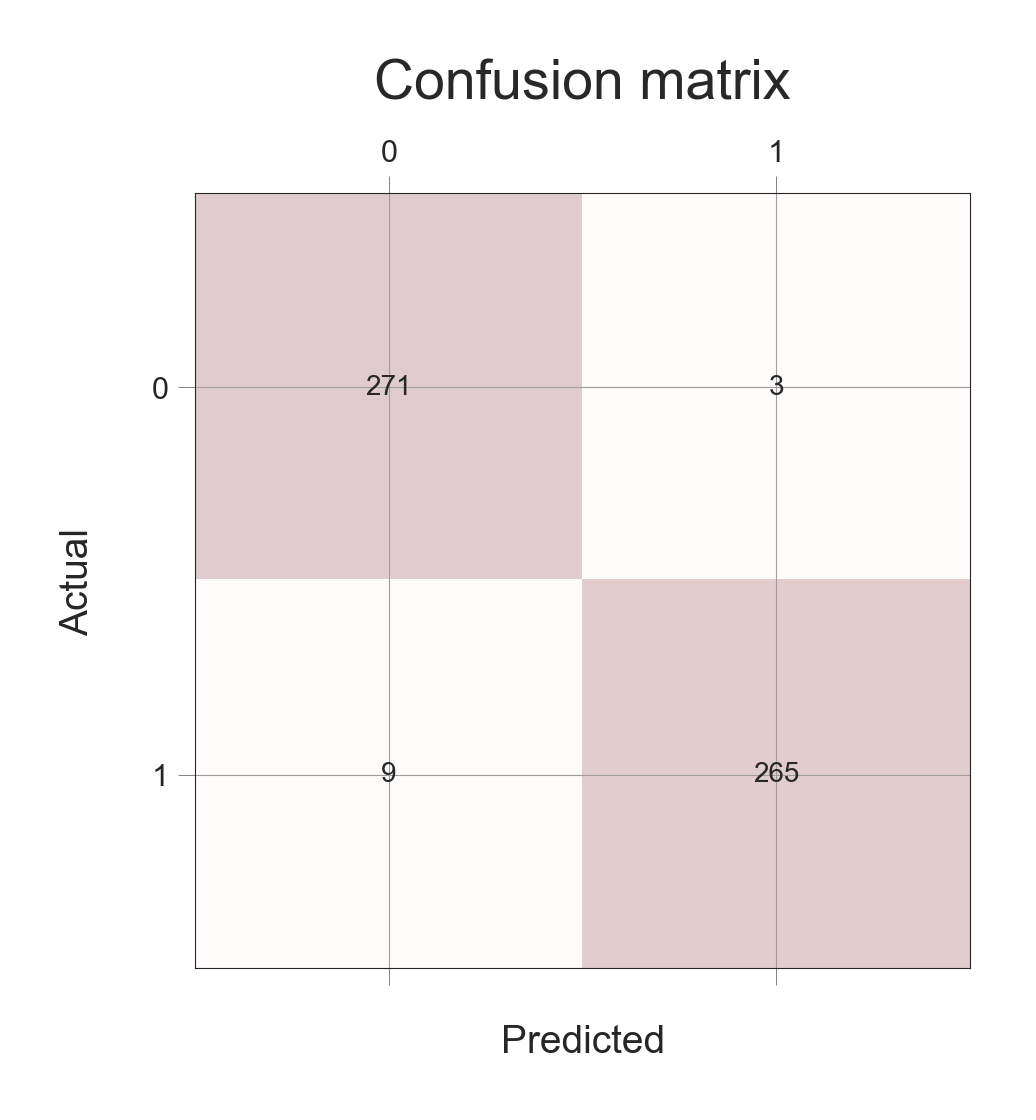

In [55]:
conf_mat = confusion_matrix(y_test, pred)
plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

# Opinion mining through Sentiment Analysis of YouTube comments

Aspect based sentiment analysis is really interesting since it gives a deep view of the variance of sentiments within a large corpus of text.

Most sentiment systems run sentiment analysis on the entire text, which sort of 'averages out' the sentiment. Running aspect based sentiment analysis on things like product reviews or YouTube comments can help the creators understand the specific parts that the users liked.

In [56]:

def get_save_data(DEVELOPER_KEY,video_id,maxPages=10):
    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    #os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"
    filename = video_id + "_data.json"
    if os.path.exists(filename):
        with open(filename) as fp:
            data = fp.read()
        data = json.loads(data)
        return data
    
    api_service_name = "youtube"
    api_version = "v3"

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey = DEVELOPER_KEY)

    result = []
    response = { 'nextPageToken' : ''}
    while True:
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            pageToken=response['nextPageToken']
        )
        response = request.execute()
        result.append(response)
        if not response['nextPageToken'] or len(result) > maxPages  :
            break

        
    with open(filename,'w+') as fp:
           fp.write(json.dumps(result)) 
    return result
    #print(response)


In [57]:
data = get_save_data("<your_google_developer_api_key>","GB_S2qFh5lU")

In [58]:
df = pd.DataFrame(snippet['snippet']['topLevelComment']['snippet'] for page in data for snippet in page['items'])
df

,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,videoId,textDisplay,textOriginal,canRate,viewerRating,likeCount,publishedAt,updatedAt
0,Milky Smoove,https://yt3.ggpht.com/a/AGF-l7-u7EvutR0GJyXYiy...,http://www.youtube.com/channel/UCqbJgXFIxTKBht...,{'value': 'UCqbJgXFIxTKBhtSOPc-Emug'},GB_S2qFh5lU,There&#39;s hella time to die. Lil xanny,There's hella time to die. Lil xanny,True,none,0,2020-02-16T04:35:26.000Z,2020-02-16T04:35:26.000Z
1,Collin McLane,https://yt3.ggpht.com/a/AGF-l79eZm6i9pjx1_6300...,http://www.youtube.com/channel/UCdpnfPv5PpWWd7...,{'value': 'UCdpnfPv5PpWWd7ver_ouFgg'},GB_S2qFh5lU,Pretty sure she just spoiled the twist with Ma...,Pretty sure she just spoiled the twist with Ma...,True,none,0,2020-02-16T04:33:10.000Z,2020-02-16T04:33:10.000Z
2,Simply Niesha,https://yt3.ggpht.com/a/AGF-l7-rOly2LQefAMwdOe...,http://www.youtube.com/channel/UC9RR5josIw0TUj...,{'value': 'UC9RR5josIw0TUjXhdJmp0CA'},GB_S2qFh5lU,This sounds like something from pretty little ...,This sounds like something from pretty little ...,True,none,0,2020-02-16T04:33:00.000Z,2020-02-16T04:33:00.000Z
3,Madilyn Morris,https://yt3.ggpht.com/a/AGF-l7_cv-IhVKSUhZ0p49...,http://www.youtube.com/channel/UC6-8JlJKfQH3G4...,{'value': 'UC6-8JlJKfQH3G4F7pUuoKpg'},GB_S2qFh5lU,OMG I love this and you Billie ♥️♥️,OMG I love this and you Billie ♥️♥️,True,none,0,2020-02-16T04:31:43.000Z,2020-02-16T04:31:43.000Z
4,DrummerChick,https://yt3.ggpht.com/a/AGF-l79u6Ia1yZ9Hn4TbFR...,http://www.youtube.com/channel/UCLLH-HP06kaUzi...,{'value': 'UCLLH-HP06kaUzinPjEaOupg'},GB_S2qFh5lU,This is a masterpiece. I had chills the whole ...,This is a masterpiece. I had chills the whole ...,True,none,0,2020-02-16T04:31:37.000Z,2020-02-16T04:31:37.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...
1095,Rosalinda Martinez,https://yt3.ggpht.com/a/AGF-l78vsl8sLif6yt-Nc3...,http://www.youtube.com/channel/UCiJg--rJOguL9r...,{'value': 'UCiJg--rJOguL9r1ybfkN3kQ'},GB_S2qFh5lU,This is like the best song(๑♡⌓♡๑),This is like the best song(๑♡⌓♡๑),True,none,0,2020-02-15T22:46:11.000Z,2020-02-15T22:46:11.000Z
1096,CraftyCarrot,https://yt3.ggpht.com/a/AGF-l7_E3M2gskzV7apU_l...,http://www.youtube.com/channel/UCrPmk2FzUWcBrv...,{'value': 'UCrPmk2FzUWcBrvtWWwEdS7w'},GB_S2qFh5lU,"Eyo MHA fans out there, can we agree that Bill...","Eyo MHA fans out there, can we agree that Bill...",True,none,0,2020-02-15T22:46:02.000Z,2020-02-15T22:46:02.000Z
1097,Andreas M,https://yt3.ggpht.com/a/AGF-l78TyvtKCNAKZHNscF...,http://www.youtube.com/channel/UCiEys_aYIpUsKJ...,{'value': 'UCiEys_aYIpUsKJ4m9EJho9g'},GB_S2qFh5lU,Ellie billiesh,Ellie billiesh,True,none,0,2020-02-15T22:46:01.000Z,2020-02-15T22:46:01.000Z
1098,gaby rego,https://yt3.ggpht.com/a/AGF-l7_aJg7PLZ6dK9USoQ...,http://www.youtube.com/channel/UCnixxin2YoVO7s...,{'value': 'UCnixxin2YoVO7s0TdVTHYPA'},GB_S2qFh5lU,ok Billie DID THAT,ok Billie DID THAT,True,none,0,2020-02-15T22:44:57.000Z,2020-02-15T22:44:57.000Z


In [59]:
df.size

13200

In [60]:
result = list(df['textOriginal'])
result = result[:100]

In [61]:
%matplotlib inline
from textblob import TextBlob, Word
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import re
import nltk
sns.set(color_codes=True)

In [62]:
import csv 

result[:10]

["There's hella time to die. Lil xanny",
 'Pretty sure she just spoiled the twist with Madeleine possibly betraying Bond',
 'This sounds like something from pretty little liars',
 'OMG I love this and you Billie ♥️♥️',
 'This is a masterpiece. I had chills the whole time ❤',
 'It would perfectly fit for a love story between a vampire and human ,like if u know what i mean❤',
 '🇩🇿🇩🇿🇩🇿💪💪💪❤❤',
 'Hey Google show me that one picture of me and Loretta',
 '“I surge on the uprising wave of love. My life can be summed up in 3 accounts:\nI was raw. I was cooked and I was burned. \nI surge on the uprising wave of love. No gravity can stop me from rising. The Moon pulls the tide of love towards her and my soul in oneness with life answers her call. A wave of love consumes me and upwards I fly.\nFlying through water to meet her shining body led by my heart my wits are idled and my mind becomes a blurry mess and so I feel instead...\n...feel the truth of her love and the divine reflection she shines 

In [63]:

nltk.download('punkt')

def clean_sentence(sentence):
    sentence = re.sub(r"(?:\@|https?\://)\S+|\n+", "", sentence.lower())
    # Fix spelling errors in comments!
    sent = TextBlob(sentence)
    sent.correct()
    clean = ""
    for sentence in sent.sentences:    
        words = sentence.words
        # Remove punctuations
        words = [''.join(c for c in s if c not in punctuation) for s in words]
        words = [s for s in words if s]
        clean += " ".join(words)
        clean += ". "
    return clean

result = [clean_sentence(x) for x in result]
result[:10]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aishw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['there s hella time to die. lil xanny. ',
 'pretty sure she just spoiled the twist with madeleine possibly betraying bond. ',
 'this sounds like something from pretty little liars. ',
 'omg i love this and you billie ♥️♥️. ',
 'this is a masterpiece. i had chills the whole time ❤. ',
 'it would perfectly fit for a love story between a vampire and human like if u know what i mean❤. ',
 '🇩🇿🇩🇿🇩🇿💪💪💪❤❤. ',
 'hey google show me that one picture of me and loretta. ',
 '“ i surge on the uprising wave of love. my life can be summed up in 3 accounts i was raw. i was cooked and i was burned. i surge on the uprising wave of love. no gravity can stop me from rising. the moon pulls the tide of love towards her and my soul in oneness with life answers her call. a wave of love consumes me and upwards i flyflying through water to meet her shining body led by my heart my wits are idled and my mind becomes a blurry mess and so i feel instead feel the truth of her love and the divine reflection she shine

In [64]:
sentiment_scores = list()
i = 0
for sentence in result:
    line = TextBlob(sentence)
    sentiment_scores.append(line.sentiment.polarity)
    if(i <= 10):
        print(sentence + ": POLARITY=" + str(line.sentiment.polarity))
        i += 1

there s hella time to die. lil xanny. : POLARITY=0.0
pretty sure she just spoiled the twist with madeleine possibly betraying bond. : POLARITY=0.25
this sounds like something from pretty little liars. : POLARITY=0.03125
omg i love this and you billie ♥️♥️. : POLARITY=0.5
this is a masterpiece. i had chills the whole time ❤. : POLARITY=0.2
it would perfectly fit for a love story between a vampire and human like if u know what i mean❤. : POLARITY=0.3
🇩🇿🇩🇿🇩🇿💪💪💪❤❤. : POLARITY=0.0
hey google show me that one picture of me and loretta. : POLARITY=0.0
“ i surge on the uprising wave of love. my life can be summed up in 3 accounts i was raw. i was cooked and i was burned. i surge on the uprising wave of love. no gravity can stop me from rising. the moon pulls the tide of love towards her and my soul in oneness with life answers her call. a wave of love consumes me and upwards i flyflying through water to meet her shining body led by my heart my wits are idled and my mind becomes a blurry mess a

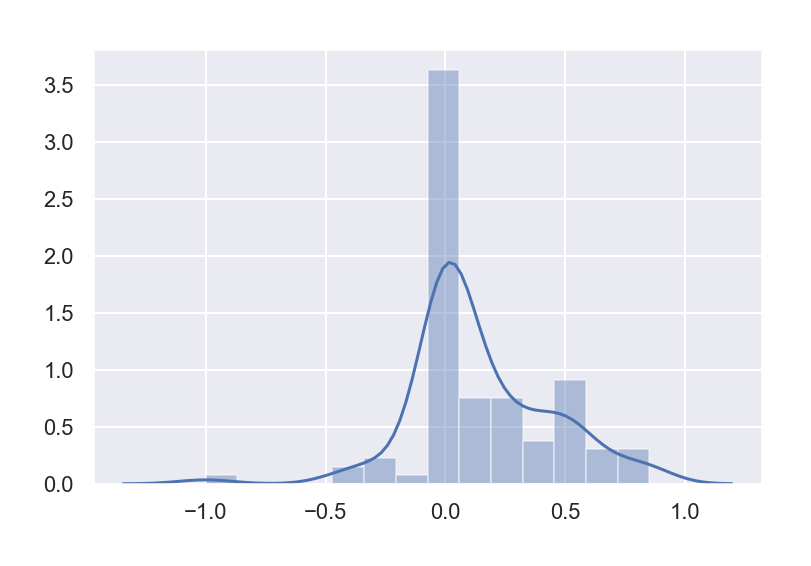

In [65]:
sns.distplot(sentiment_scores)

We can see that a majority of the comments are marked as neutral (though slightly on the positive side). This basically implies that TextBlob SA 'averages' out over a sentence.

So for a sentence containing : "Love your videos and humor." the polarity is 0.167 plainly because it is also followed by "curiously once training is complete how do you feed a movie review into the model or access the model ie where is model saved at the completion of training".

In [66]:
comments = TextBlob(' '.join(result))

In [67]:
import nltk
nltk.download('brown')
comments.noun_phrases

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\aishw\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


WordList(['s hella time', 'lil xanny', 'pretty little liars', 'omg i', 'billie ♥️♥️', 'whole time ❤', 'i mean❤', 'hey google show', '“ i surge', 'accounts i', 'i surge', 'moon pulls', 'life answers', 'blurry mess', 'divine reflection', 'radiant heart ” rumithis', 'beautiful piece', 'beautiful sylvia', '“ dm', 'chaos destruction ”', 'link twinflames', 'adele skyfall type', 'right i', 'hola tod', 'd ruin thislike cmon guys', 'ca nt', 'time i', 'bits i', 'nt catch', 'woman french singer', 'billie sings', 'whispery i', 'e x t r', '’ s alright tenth time', 'song i', 'sou o comentário em português que tu tá procurandops', 'musica boa pra caralho', 'major joker vibes', 'honest i', 'bond movie', 'time respect', 'hello dear', 'joni mitchell', 'cod zombies', 'hello dear', 'joni mitchell', 'hello dear', 'joni mitchell', 'hello dear', 'joni mitchell', 'spider ina', 'song sucks', 'bond song', 'james bond film', 'lana wannabe', 'ok adeles', 'hört sich immer gleich depri', 'beutifull voice', 'model i

# Pruning

Quite a lot of these noun phrases are repeated or have the same subset of words. We now run modified versions of redundancy pruning and compactness pruning.
Compactness pruning:

We check for compact phrases and see if the words in the phrases make sense. For e.g the phrase "i m" fails the compact pruning test and is pruned. A simple way to carry out compact pruning is by checking the words in a phrase and seeing if a dictionary meaning exists. If the number of words in the phrase without dictionary meanings cross a certain threshold, we prune the phrase.

In [68]:
import nltk
nltk.download('wordnet')

cleaned = list()
for phrase in comments.noun_phrases:
    count = 0
    for word in phrase.split():
        # Count the number of small words and words without an English definition
        if len(word) <= 2 or (not Word(word).definitions):
            count += 1
    # Only if the 'nonsensical' or short words DO NOT make up more than 40% (arbitrary) of the phrase add
    # it to the cleaned list, effectively pruning the ones not added.
    if count < len(phrase.split())*0.4:
        cleaned.append(phrase)
        
print("After compactness pruning:\nFeature Size:" + str(len(cleaned)))
#len(cleaned)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aishw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


After compactness pruning:
Feature Size:56


# Redundancy pruning:

I am using a naive decision of choosing the largest common noun phrase as a non-redundant feature. A better way would be to find 'important' terms in common noun phrases and choose those. One approach to that could be something called TF-IDF.

In [69]:
for phrase in cleaned:    
    match = list()
    temp = list()
    word_match = list()
    for word in phrase.split():
        # Find common words among all phrases
        word_match = [p for p in cleaned if re.search(word, p) and p not in word_match]
        # If the size of matched phrases set is smaller than 30% of the cleaned phrases, 
        # then consider the phrase as non-redundant.
        if len(word_match) <= len(cleaned)*0.3 :
            temp.append(word)
            match += word_match
            
    phrase = ' '.join(temp)
#     print("Match for " + phrase + ": " + str(match))

    if len(match) >= len(cleaned)*0.1 :
        # Redundant feature set, since it contains more than 10% of the number of phrases. 
        # Prune all matched features.
        for feature in match:
            if feature in cleaned:
                cleaned.remove(feature)
            
        # Add largest length phrase as feature
        cleaned.append(max(match, key=len))
        

print("After redundancy pruning:\nFeature Size:" + str(len(cleaned)))
#print("Cleaned features:")
#cleaned

After redundancy pruning:
Feature Size:37


In [70]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
feature_count = dict()
for phrase in cleaned:
    count = 0
    for word in phrase.split():
        if word not in stopwords.words('english'):
            count += comments.words.count(word)
    
    #print(phrase + ": " + str(count))
    feature_count[phrase] = count

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aishw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
counts = list(feature_count.values())
features = list(feature_count.keys())
threshold = len(comments.noun_phrases)/100

print("Threshold:" + str(threshold))

frequent_features = list()

for feature, count in feature_count.items():
    if count >= threshold:
        frequent_features.append(feature)
        
#print('Frequent Features:')
#frequent_features

Threshold:1.33


In [72]:
#sns.set()
#sns.set_context("poster")
#f, ax = plt.subplots(figsize=(10, 50))
#sns.swarmplot(y=features, x=counts, color="c", ax=ax)
#plt.plot([threshold, threshold], [0, len(features)], linewidth=4, color="r")

In [73]:
absa_list = dict()
# For each frequent feature
for f in frequent_features:
    # For each comment
    absa_list[f] = list()
    for comment in result:
        blob = TextBlob(comment)
        # For each sentence of the comment
        for sentence in blob.sentences:
            # Search for frequent feature 'f'
            q = '|'.join(f.split())
            if re.search(r'\w*(' + str(q) + ')\w*', str(sentence)):
                absa_list[f].append(sentence)


# Aspect based sentiment scoring

Now that we have aspect specific sentences, all we have to do is run sentiment analysis on each sentence using TextBlob's sentiment analyzer.

In [74]:
scores = list()
absa_scores = dict()
for k, v in absa_list.items():
    absa_scores[k] = list()
    for sent in v:
        score = sent.sentiment.polarity
        scores.append(score)
        absa_scores[k].append(score)

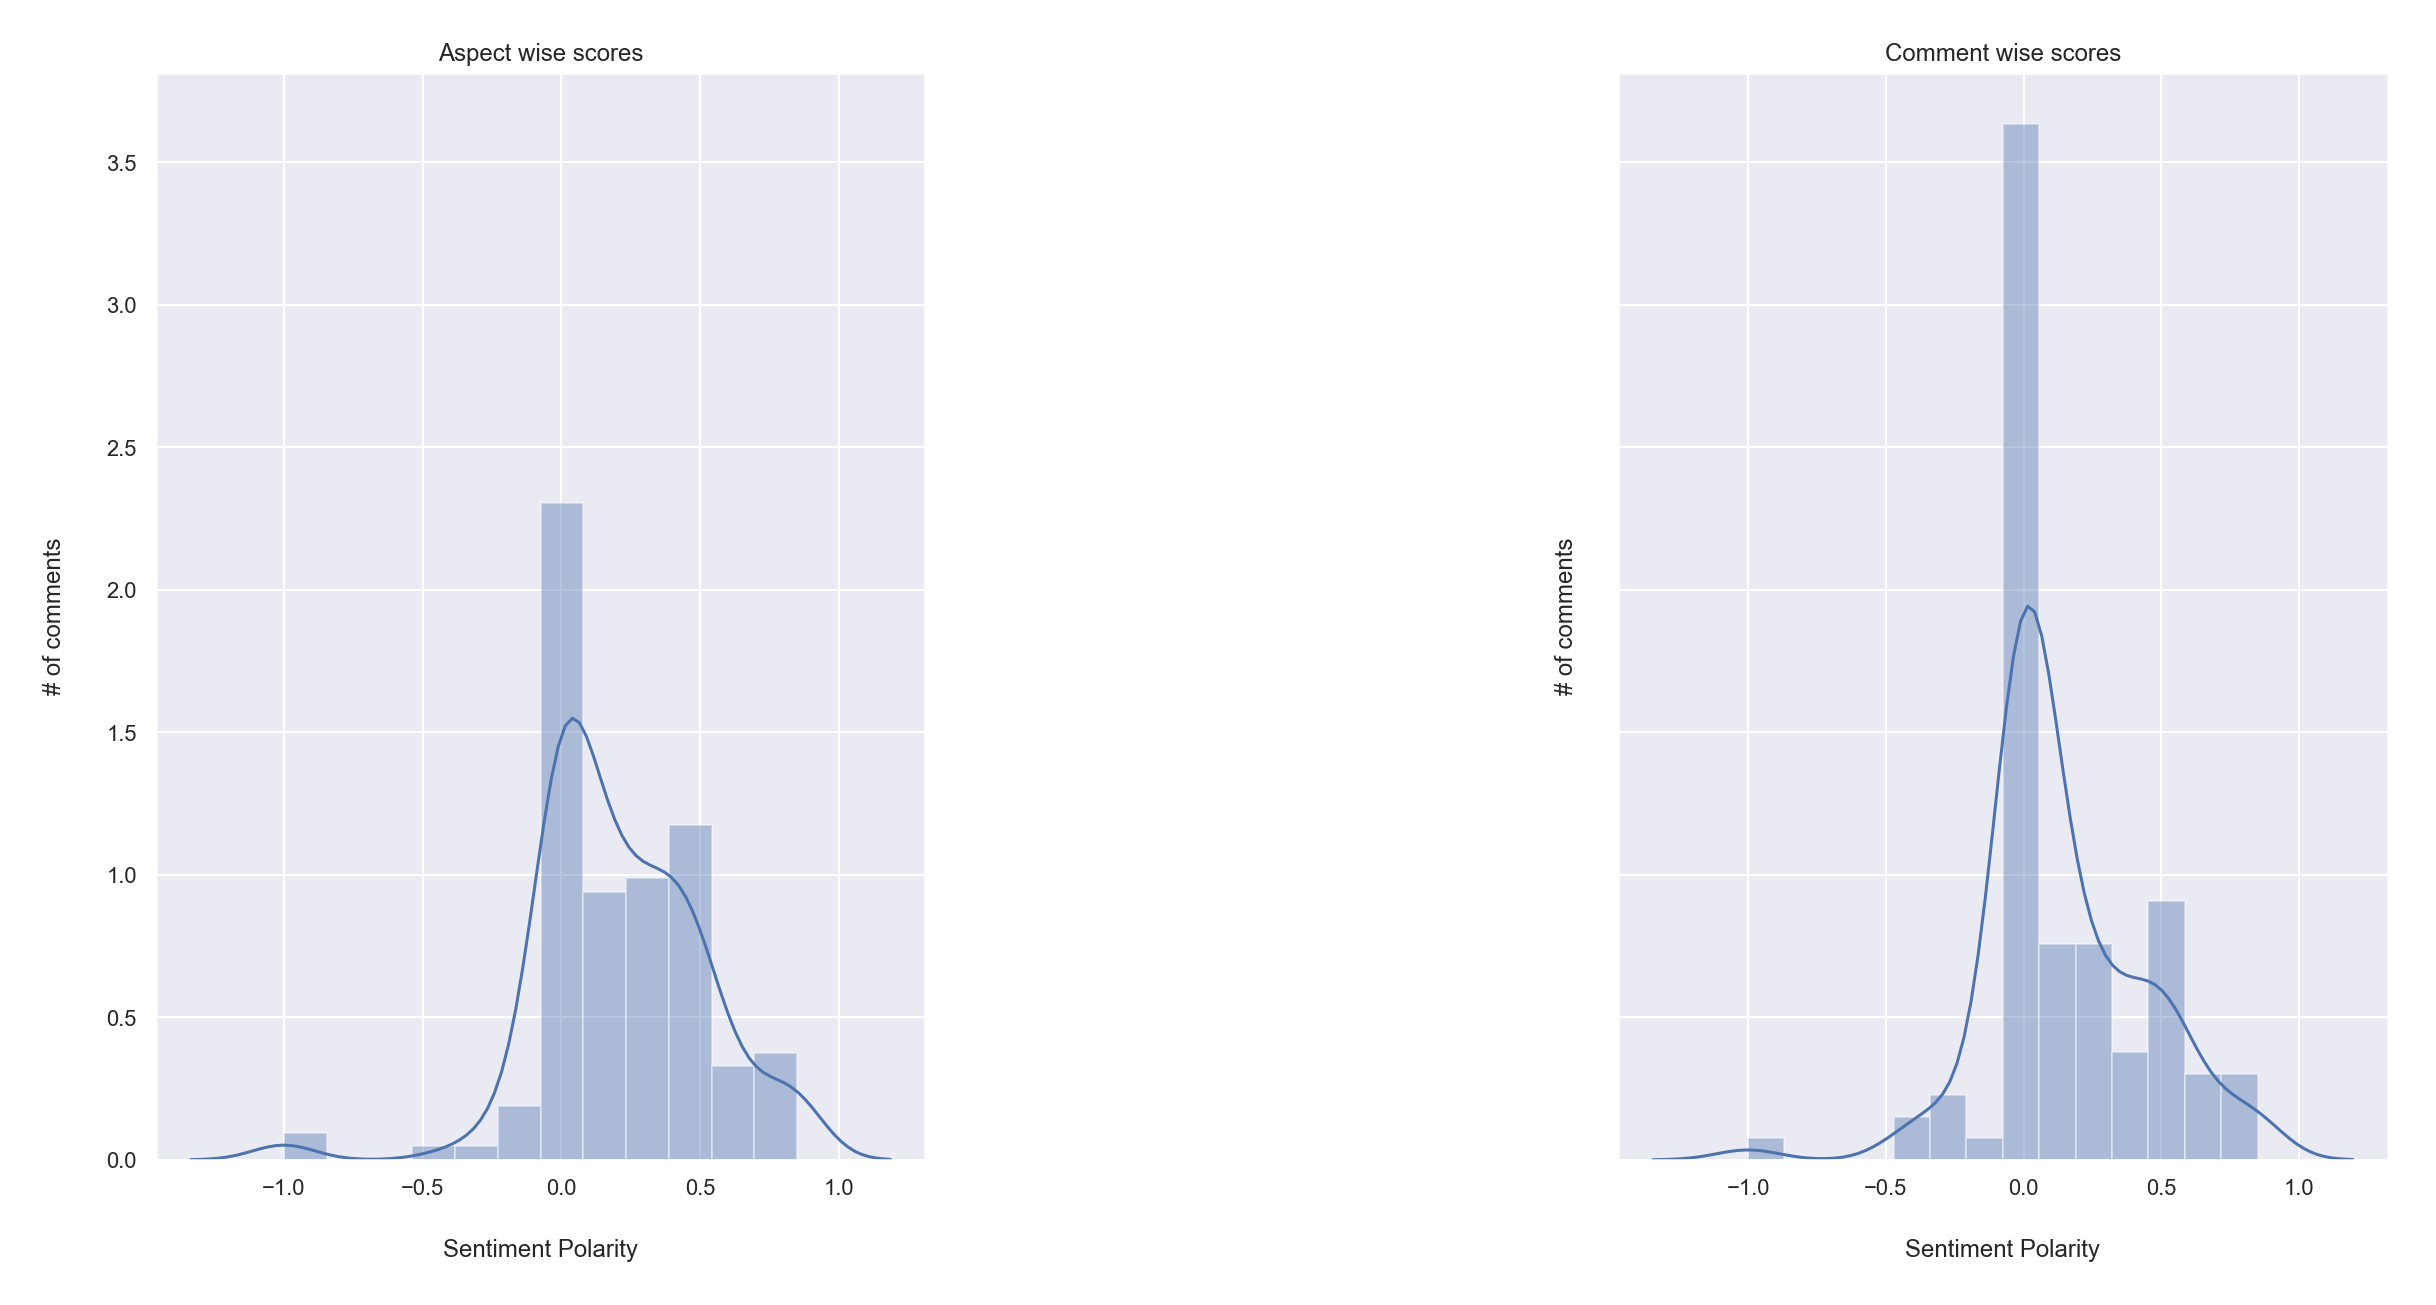

In [75]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(20, 10))
plot1 = sns.distplot(scores, ax=ax1)

ax1.set_title('Aspect wise scores')
ax1.set_xlabel('Sentiment Polarity')
ax1.set_ylabel('# of comments')

ax2.set_title('Comment wise scores')
ax2.set_xlabel('Sentiment Polarity')
ax2.set_ylabel('# of comments')

plot2 = sns.distplot(sentiment_scores, ax=ax2)

# Graph Analysis

Notice the high amount of variance in the aspect based scores on the left. Even though a majority of the scores are neutral, there is lot of variance in the number of comments with positive sentiments. The total number of scores have also increased since one sentence of a comment may contain multiple frequent features.

In [76]:
vals = dict()
vals["aspects"] = list()
vals["scores"] = list()
for k, v in absa_scores.items():
    for score in v:
        vals["aspects"].append(k)
        vals["scores"].append(score)

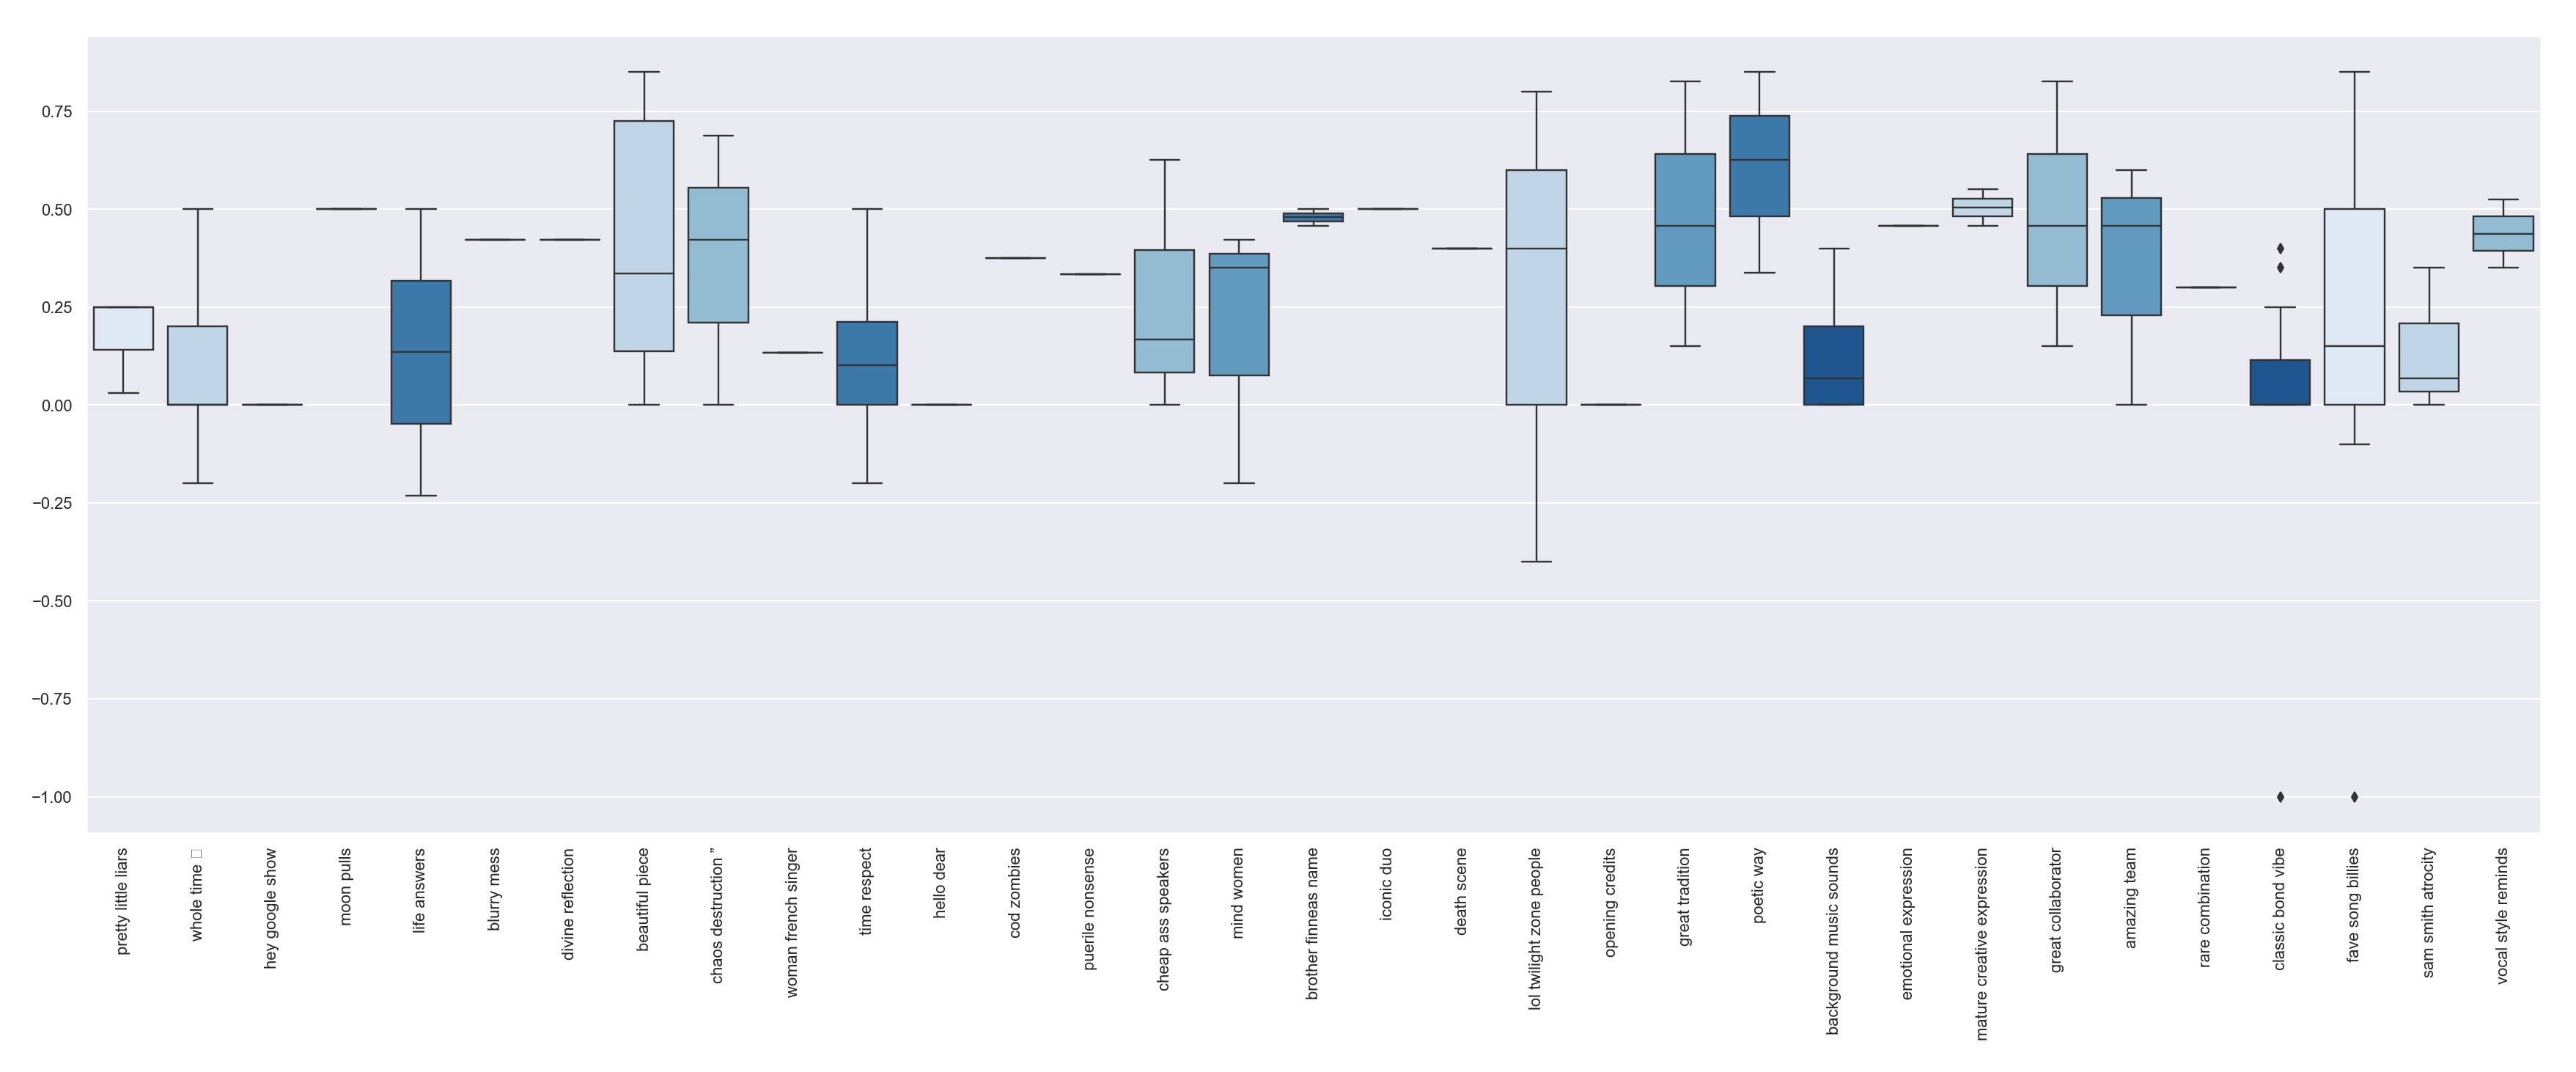

In [77]:
fig, ax1 = plt.subplots(figsize=(30, 10))

color = sns.color_palette("Blues", 6)
plt.xticks(rotation=90)
sns.set_context("paper", font_scale=3) 
sns.boxplot(x="aspects", y="scores", data=vals, palette=color, ax=ax1)

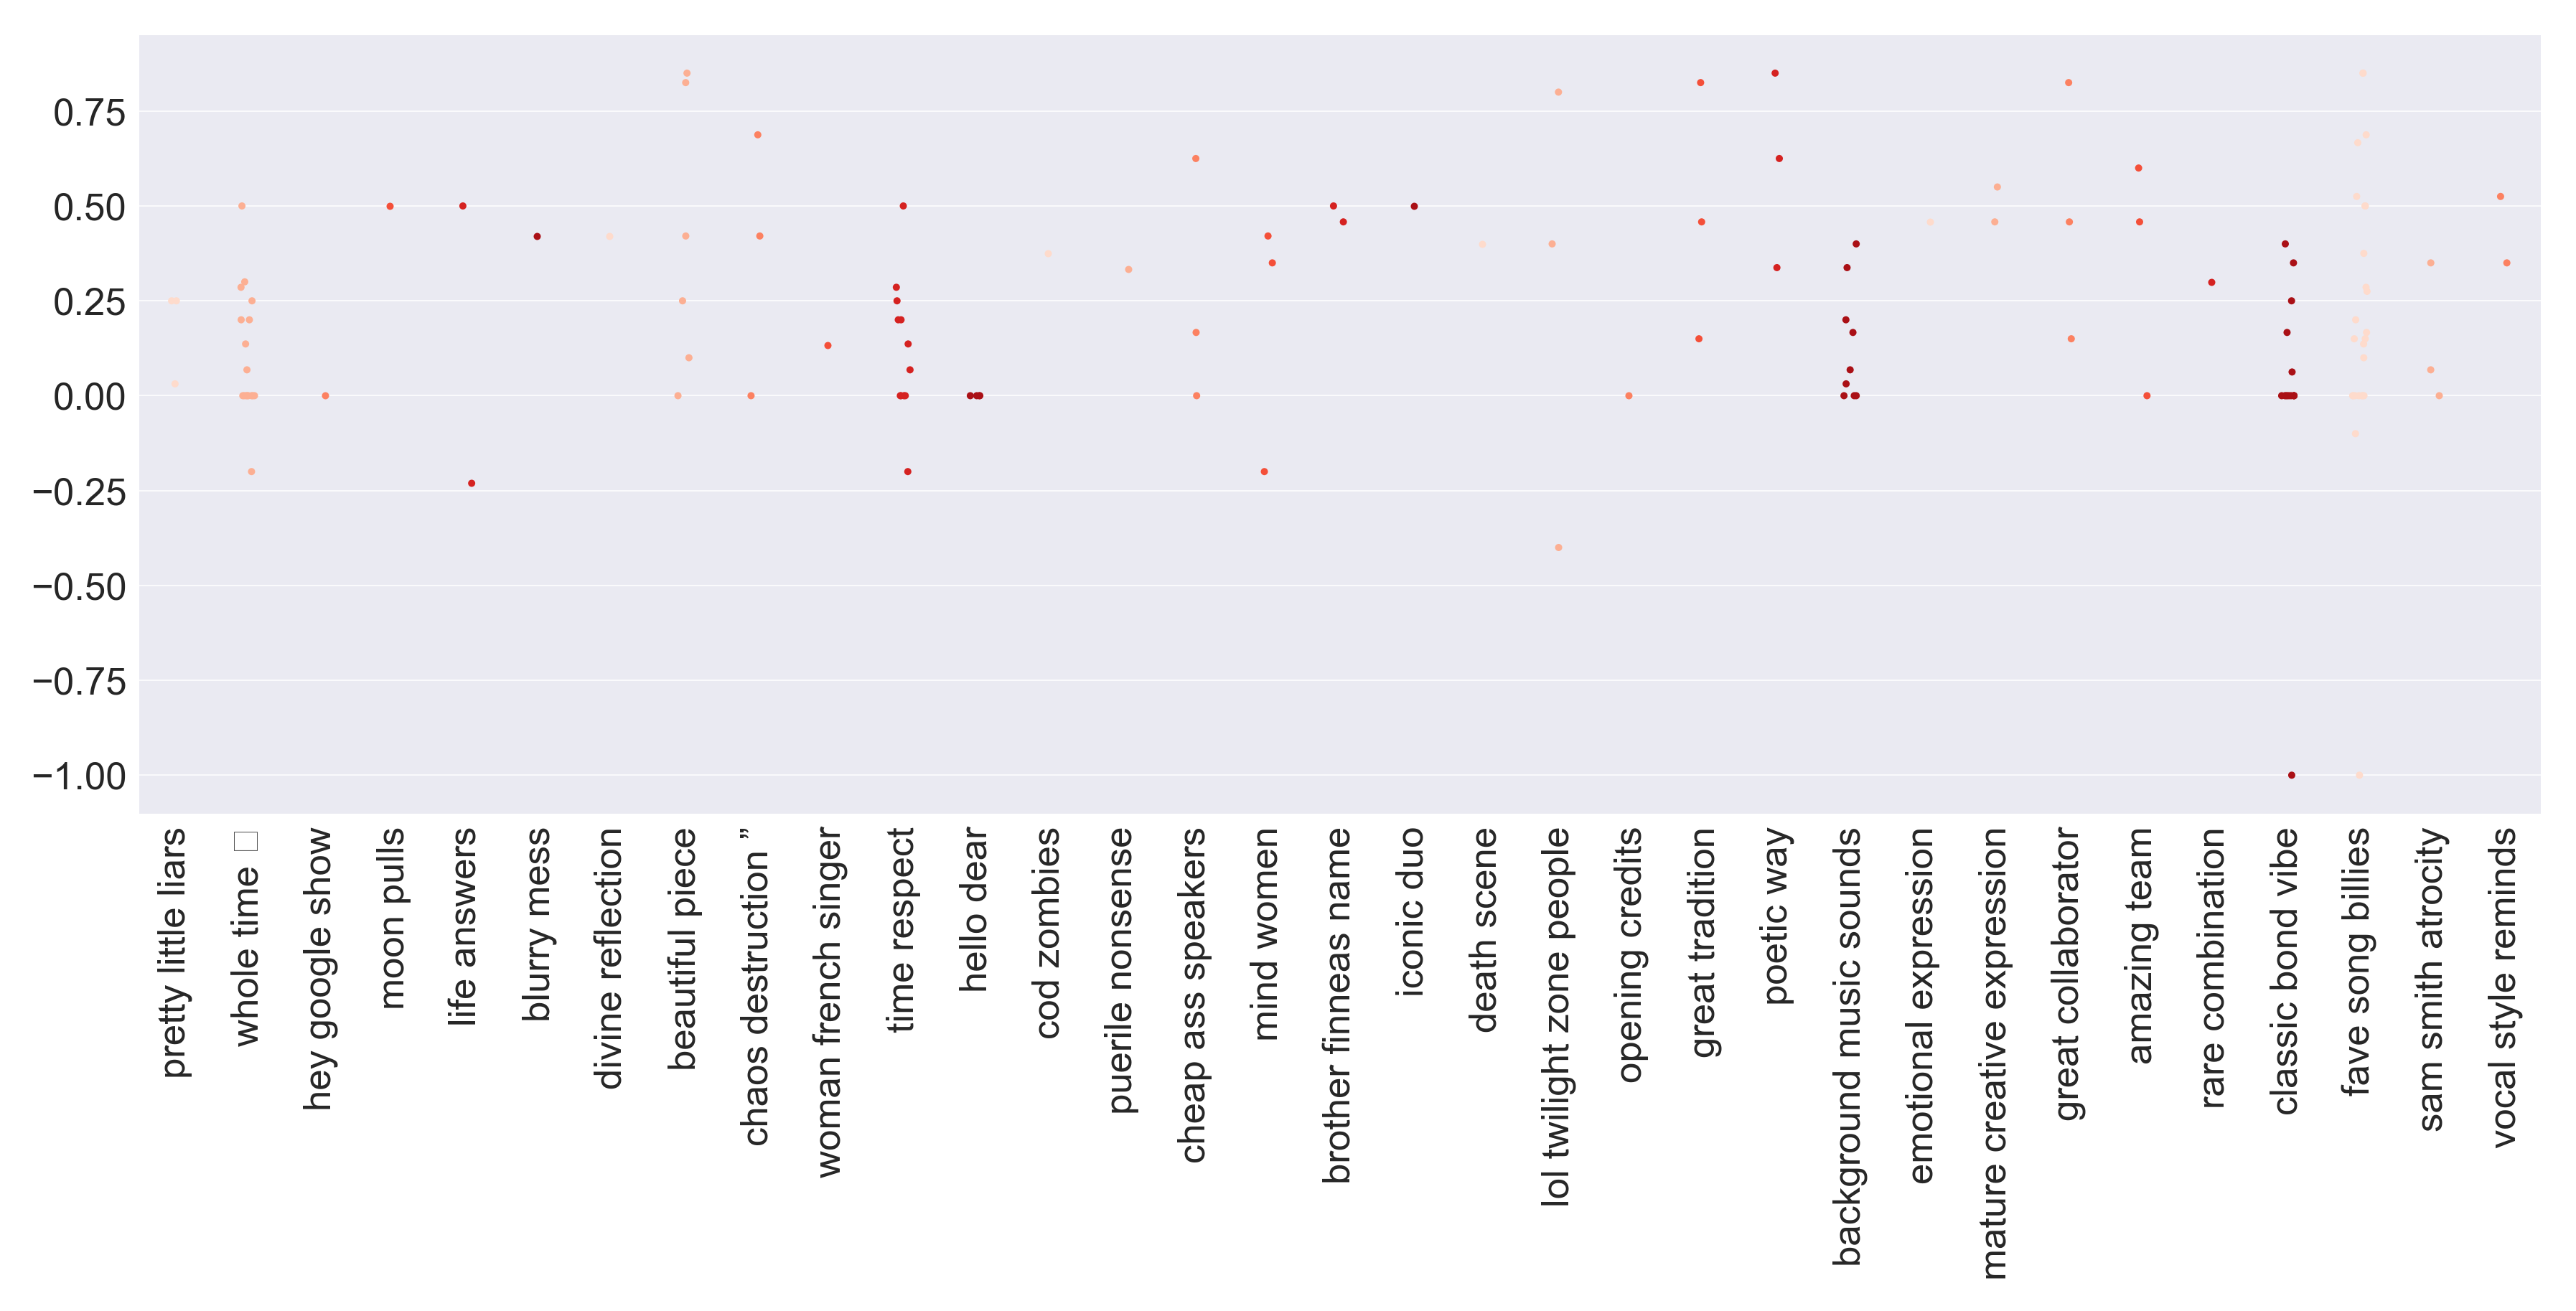

In [78]:
color = sns.color_palette("Reds", 6)
fig, ax1 = plt.subplots(figsize=(30, 10))
plt.xticks(rotation=90)
sns.set_context("paper", font_scale=2) 
sns.stripplot(x="aspects", y="scores",data=vals, palette=color)

## <a name="conc"></a>Conclusions
Here are the some of the results we extracted from the analysis:
1. We analyzed a dataset that contains information about YouTube trending videos for 20 days. The dataset was collected in   2019. It contains **`1122`** video entries.

2. We ran Aspect Based Sentiment Analysis (ABSA) on a YouTube video and found that ABSA actually gives a more in-depth understanding of people's reviews.
3. The Largest number of trending videos come under the **`Entertainment`** Category and **`Good Mythical Morning`** Channel have the largest number of trending video 
4. We used a Stochastic Gradient Decent Classifier to train a model which classifies the trending and non trending video based on various parameters.
5. The model displayed approximately **`97%`** accuracy on the test set